# Self-supervised Vision Transformer for Land Cover Segmentation
### Pre-trained model with Swin Transformer and Sentinel-1/2, segmentation head trained with Flair1


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/BertilleT/LandCover_map_Transformers_SSL.git

Cloning into 'LandCover_map_Transformers_SSL'...
remote: Enumerating objects: 8729, done.
remote: Counting objects: 100% (312/312), done.
remote: Compressing objects: 100% (215/215), done.
remote: Total 8729 (delta 129), reused 269 (delta 87), pack-reused 8417
Receiving objects: 100% (8729/8729), 429.81 MiB | 25.12 MiB/s, done.
Resolving deltas: 100% (564/564), done.


In [3]:
cd LandCover_map_Transformers_SSL/src

/content/LandCover_map_Transformers_SSL/src


## Content

1. [Installation](#installation)
1. [Dataset](#dataset)
1. [Quick Start](#quickstart)

In [4]:
!pip install wandb
!pip install rasterio
!pip install timm
!pip install einops
!pip install diffdist
!pip install GPUtil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for diffdist: filename=diffdist-0.1-py3-none-any.whl size=6534 sha256=d4d3ff43144b4cff2535fa1b4702464455fcd8b6c3b5200526edc6821e699204
  Stored in directory: /root/.cache/pip/wheels/f1/29/f6/5331a14ab74e769799b76eb32460f447c7feb7375a16b07854
Successfully built diffdist
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl 

In [5]:
# Import needed packages
import json
import random
import numpy as np
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import psutil
import GPUtil
sys.path.append('../..')
from tools.utils_Flair1 import *
from tools.metrics import PixelwiseMetrics
from Transformer_SSL.models import build_model
from Transformer_SSL.models.swin_transformer import SwinTransformerDecoder
import csv

### Quick Start
You can specify in the some hyperparameters in train_config (cell below), such as the learning_rate, the batch_size, number of epochs, or if you wish to fine-tune the model or not (with the finetuning argument), etc.

In [6]:
# Data configurations:
data_config = {
    'train_dir': '../../drive/MyDrive/MVA/flair1_fullset_13classes/train', # path to the training directory,
    'val_dir': '../../drive/MyDrive/MVA/flair1_fullset_13classes/val', # path to the validation directory,
    'test_dir': '../../drive/MyDrive/MVA/flair1_fullset_13classes/test', # path to the validation directory,
    'train_mode': 'validation', # can be one of the following: 'test', 'validation'
    'val_mode': 'test', # can be one of the following: 'test', 'validation'
    'num_classes': 13, # number of classes in the dataset.
    'clip_sample_values': True, # clip (limit) values
    'train_used_data_fraction': 1, # fraction of data to use, should be in the range [0, 1]
    'val_used_data_fraction': 1,
    'image_px_size': 224, # image size (224x224)
    'cover_all_parts_train': True, # if True, if image_px_size is not 224 during training, we use a random crop of the image
    'cover_all_parts_validation': True, # if True, if image_px_size is not 224 during validation, we use a non-overlapping sliding window to cover the entire image
    'seed': 42,
}

In [7]:
# Ensure deterministic behavior
random.seed(data_config['seed'])
np.random.seed(data_config['seed'])
torch.manual_seed(data_config['seed'])
torch.cuda.manual_seed_all(data_config['seed'])

#### Prepare

We create the `train_dataset` and `val_dataset` by using the `DFCDataset`, a custom class of `torch.utils.data.Dataset`

In [8]:
#from dfc_dataset import DFCDataset
size = 224
multimodal = True
train_dataset = Flair1Dataset_SSL(data_config['train_dir'], size, multimodal)
val_dataset = Flair1Dataset_SSL(data_config['val_dir'], size, multimodal)
test_dataset = Flair1Dataset_SSL(data_config['test_dir'], size, multimodal)

We can see how many examples are in each split by checking their length:

In [9]:
len(train_dataset), len(val_dataset)

(1664, 416)

In [10]:
#loop on train_ds and check shape of rgb and ir_el
rgb = train_dataset[0][0]['rgb']
ir_el = train_dataset[0][0]['ir_el']
print(rgb.shape)
print(ir_el.shape)

torch.Size([3, 224, 224])
torch.Size([2, 224, 224])


We define a correspondance of label and names:

In [11]:
dict_classes_13 = {
1   : 'building',
2   : 'pervious surface',
3   : 'impervious surface',
4   : 'bare soil',
5   : 'water',
6   : 'coniferous',
7   : 'deciduous',
8   : 'brushwood',
9   : 'vineyard',
10  : 'herbaceous vegetation',
11  : 'agricultural land',
12  : 'plowed land',
13  : 'other'}

Our data is now ready to be used by the model. In the next section we load and configure the model.

<a id='quickstart'></a>
## 3. Quick Start

#### Configure

You can specify in the some hyperparameters in `train_config` (cell below), such as the `learning_rate`, the `batch_size`, number of `epochs`, or if you wish to fine-tune the model or not (with the `finetuning` argument), etc.

In [12]:
# Training configurations
train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'finetuning': True, # If false, backbone layers is frozen and only the head is trained
    'classifier_lr': 3e-6,
    'learning_rate': 0.00001,
    'adam_betas': (0.9, 0.999),
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 16,
    'epochs': 60,
    'target': 'dfc_label'
}

#### Download checkpoint

You can download the pre-trained backbone model using this [link](https://drive.google.com/file/d/1e7QhC2-zoBFgb65yN1ADWBZLMShHOweY/view), save it in the `checkpoints/` directory then run the following cell.

Make sure to properly modify the path to the downloaded checkpoint in the path below.

In the case where you are using a uni-modal dataset (Sentinel-2 only or Sentinel-1 only), you can load the corresponding weight stream `s1_weights` or `s2_weights`, and comment the other one.

In [13]:
# path to the checkpoint
checkpoint = torch.load(
    "../../drive/MyDrive/MVA/swin_t.pth",#, map_location=torch.device('cpu') #comment map_location if using GPU
)
weights = checkpoint["state_dict"]

# Sentinel-1 stream weights
s1_weights = {
    k[len("backbone1."):]: v for k, v in weights.items() if "backbone1" in k
}

# Sentinel-2 stream weights
s2_weights = {
    k[len("backbone2."):]: v for k, v in weights.items() if "backbone2" in k
}

#### Prepare model and load checkpoint

We prepare the model by specifying the `input_channels`: only sentinel1, only sentinel2 or both. We also specify if we need both backbones `s1_backbone` and `s2_backbone` depending on our application. In the case where only one stream is needed, just comment the lines `s1_backbone` or `s2_backbone`.

In [14]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def dotdictify(d):
    """recursively wrap a dictionary and
    all the dictionaries that it contains
    with the dotdict class
    """
    d = dotdict(d)
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = dotdictify(v)
    return d

In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu:0")

with open("configs/backbone_config.json", "r") as fp:
    swin_conf = dotdictify(json.load(fp))

s1_backbone = build_model(swin_conf.model_config)

swin_conf.model_config.MODEL.SWIN.IN_CHANS = 13
s2_backbone = build_model(swin_conf.model_config)

s1_backbone.load_state_dict(s1_weights)
s2_backbone.load_state_dict(s2_weights)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

We create the downstream model head that will be trained. In this demo, we will train a classifier. You can find a segmentation head in the repository (/TransformerSSL/models/swin_transformer/DoubleSwinTransformerSegmentation). Our classifier takes as input the pre-trained backbone (in the form of two streams `encoder1` and `encoder2`), the `out_dim` (number of classes), and `freeze_layers` flag, specifying whether you wish to freeze the backbone weights or not.

In [16]:
class DoubleSwinTransformerSegmentation(nn.Module):
    def __init__(self, encoder1, encoder2, out_dim, device, freeze_layers=False):
        super(DoubleSwinTransformerSegmentation, self).__init__()

        self.device = device

        self.backbone1 = encoder1
        self.backbone2 = encoder2

        self.decoder1 = SwinTransformerDecoder(self.backbone1, out_dim, device)
        self.decoder2 = SwinTransformerDecoder(self.backbone2, out_dim, device)

        # freeze all backbone layers
        if freeze_layers:
            for name, param in self.named_parameters():
                if name.startswith(('backbone')):
                    param.requires_grad = False

        self.expand_channels = torch.nn.Conv2d(3, 13, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        expanded_rgb = self.expand_channels(x["rgb"].to(self.device))
        _, x2, x_seg2 = self.backbone2.forward_features(expanded_rgb)

        _, x1, x_seg1 = self.backbone1.forward_features(x["ir_el"].to(self.device))

        x1 = self.decoder1.forward_up_features(x1, x_seg1)
        x2 = self.decoder2.forward_up_features(x2, x_seg2)

        x = torch.cat([x1, x2], dim=-1)

        output = self.decoder1.up_x4(x)

        return output

In [17]:
model = DoubleSwinTransformerSegmentation(
        s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device
    )

model = model.to(device)

Define and initialise the loss for training. Here we are training for single-class classification and using a `torch.nn.CrossEntropyLoss` loss.

In [18]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction="mean").to(device)

Define the trainable parameters (needed for the optimizer):

In [19]:
if train_config['finetuning']:
    # train all parameters (backbone + classifier head)
    param_backbone = []
    param_head = []
    for p in model.parameters():
        if p.requires_grad:
            param_head.append(p)
        else:
            param_backbone.append(p)
        p.requires_grad = True
    # parameters = model.parameters()
    parameters = [
        {"params": param_backbone},  # train with default lr
        {
            "params": param_head,
            "lr": train_config['classifier_lr'],
        },  # train with classifier lr
    ]
    print("Finetuning")

else:
    # train only final linear layer for SSL methods
    print("Frozen backbone")
    parameters = list(filter(lambda p: p.requires_grad, model.parameters()))

Finetuning


Initialise the selected optimizer. In this work we chose Adam optimizer. You can initialise any optimizer you want.

In [20]:
optimizer = torch.optim.Adam(
    parameters,
    lr=train_config['learning_rate'],
    betas=train_config['adam_betas'],
    weight_decay=train_config['weight_decay'],
)

We load the data (training and validation) using pytorch's dataloader

In [21]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_config['batch_size'],
    shuffle=True,
    pin_memory=True,
    num_workers=train_config['dataloader_workers'],
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=train_config['batch_size'],
    shuffle=False,
    num_workers=train_config['dataloader_workers'],
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=train_config['batch_size'],
    shuffle=False,
    num_workers=train_config['dataloader_workers'],
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Everything is set and we are now ready to train the segmentation head:

Epoch:0, Training Loss:2.459: 100%|██████████| 104/104 [09:35<00:00,  5.53s/it]


{'train_loss': 2.468355894088745, 'train_average_accuracy': 0.0851464453650228, 'train_mIoU': 0.04566977634108563, 'train_accuracy_pixelclass_0': 0.033843544469486425, 'train_accuracy_pixelclass_1': 0.03865121168776574, 'train_accuracy_pixelclass_2': 0.07463125611526233, 'train_accuracy_pixelclass_3': 0.028496703325088954, 'train_accuracy_pixelclass_4': 0.045492455472507076, 'train_accuracy_pixelclass_5': 0.03502884133488402, 'train_accuracy_pixelclass_6': 0.1232540565712472, 'train_accuracy_pixelclass_7': 0.054412082681746694, 'train_accuracy_pixelclass_8': 0.11130669125881945, 'train_accuracy_pixelclass_9': 0.4039250768731054, 'train_accuracy_pixelclass_10': 0.08597933539416203, 'train_accuracy_pixelclass_11': 0.013319334691946723, 'train_accuracy_pixelclass_12': 0.05856319986927452, 'train_IoU_class_0': 0.023030460377463695, 'train_IoU_class_1': 0.023508916976635603, 'train_IoU_class_2': 0.04559632351027561, 'train_IoU_class_3': 0.006696342535644883, 'train_IoU_class_4': 0.020987807

Validation Loss:2.317: 100%|██████████| 26/26 [00:49<00:00,  1.89s/it]


Epoch:0 {'validation_loss': 2.3169445991516113, 'validation_average_accuracy': 0.09563834896570327, 'validation_mIoU': 0.0514453703284712, 'validation_accuracy_pixelclass_0': 0.009572455886823053, 'validation_accuracy_pixelclass_1': 0.017153128564445168, 'validation_accuracy_pixelclass_2': 0.06597145391378681, 'validation_accuracy_pixelclass_3': 0.010555608866711448, 'validation_accuracy_pixelclass_4': 0.010201415196954894, 'validation_accuracy_pixelclass_5': 0.01776302985106264, 'validation_accuracy_pixelclass_6': 0.23001398893702704, 'validation_accuracy_pixelclass_7': 0.031062112166351904, 'validation_accuracy_pixelclass_8': 0.0615665078009926, 'validation_accuracy_pixelclass_9': 0.7393524824231383, 'validation_accuracy_pixelclass_10': 0.04616946234468693, 'validation_accuracy_pixelclass_11': 0.0022449992750980816, 'validation_accuracy_pixelclass_12': 0.001671891327063741, 'train_IoU_class_0': 0.00825779585934131, 'train_IoU_class_1': 0.012778309269528023, 'train_IoU_class_2': 0.043

Epoch:1, Training Loss:2.249: 100%|██████████| 104/104 [07:34<00:00,  4.37s/it]


{'train_loss': 2.251753330230713, 'train_average_accuracy': 0.1023536345865918, 'train_mIoU': 0.05283915384618379, 'train_accuracy_pixelclass_0': 0.005254206822172753, 'train_accuracy_pixelclass_1': 0.00866459929359112, 'train_accuracy_pixelclass_2': 0.03487378287864989, 'train_accuracy_pixelclass_3': 0.005902371926924244, 'train_accuracy_pixelclass_4': 0.009186316210511712, 'train_accuracy_pixelclass_5': 0.02209998542238377, 'train_accuracy_pixelclass_6': 0.3039459593910844, 'train_accuracy_pixelclass_7': 0.020672051620914293, 'train_accuracy_pixelclass_8': 0.032505017587821816, 'train_accuracy_pixelclass_9': 0.8481220581650467, 'train_accuracy_pixelclass_10': 0.036567912801748016, 'train_accuracy_pixelclass_11': 0.0011916143879952335, 'train_accuracy_pixelclass_12': 0.0016113731168495159, 'train_IoU_class_0': 0.0047356723985534505, 'train_IoU_class_1': 0.007222525990014974, 'train_IoU_class_2': 0.027350211136484445, 'train_IoU_class_3': 0.0036699310582972967, 'train_IoU_class_4': 0.0

Validation Loss:2.158: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch:1 {'validation_loss': 2.157782793045044, 'validation_average_accuracy': 0.11020631675425153, 'validation_mIoU': 0.05636871580176048, 'validation_accuracy_pixelclass_0': 0.0013037282993869144, 'validation_accuracy_pixelclass_1': 0.004367972950953235, 'validation_accuracy_pixelclass_2': 0.017832793389805184, 'validation_accuracy_pixelclass_3': 0.000934567741558642, 'validation_accuracy_pixelclass_4': 0.016246316870759333, 'validation_accuracy_pixelclass_5': 0.024919885228242792, 'validation_accuracy_pixelclass_6': 0.40960340053348016, 'validation_accuracy_pixelclass_7': 0.013963141767187522, 'validation_accuracy_pixelclass_8': 0.008252493221626998, 'validation_accuracy_pixelclass_9': 0.9194894514524362, 'validation_accuracy_pixelclass_10': 0.015724432900222497, 'validation_accuracy_pixelclass_11': 4.393344961052997e-05, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.0012492875383809969, 'train_IoU_class_1': 0.003803390684220141, 'train_IoU_class_2': 0.015521571638

Epoch:2, Training Loss:2.119: 100%|██████████| 104/104 [06:34<00:00,  3.80s/it]


{'train_loss': 2.1237027645111084, 'train_average_accuracy': 0.11720058760369409, 'train_mIoU': 0.059511834561095066, 'train_accuracy_pixelclass_0': 0.0021231911778487557, 'train_accuracy_pixelclass_1': 0.002324835712437025, 'train_accuracy_pixelclass_2': 0.015284236269183835, 'train_accuracy_pixelclass_3': 0.00039521352508508067, 'train_accuracy_pixelclass_4': 0.019285886344753676, 'train_accuracy_pixelclass_5': 0.020723624357175008, 'train_accuracy_pixelclass_6': 0.5073385297711858, 'train_accuracy_pixelclass_7': 0.012294598806553458, 'train_accuracy_pixelclass_8': 0.011616654851265543, 'train_accuracy_pixelclass_9': 0.917044981797451, 'train_accuracy_pixelclass_10': 0.015073675698238387, 'train_accuracy_pixelclass_11': 1.5968031999936128e-05, 'train_accuracy_pixelclass_12': 8.624250484546704e-05, 'train_IoU_class_0': 0.00203989354766812, 'train_IoU_class_1': 0.00215166671156702, 'train_IoU_class_2': 0.01364968506498104, 'train_IoU_class_3': 0.00036908513925727044, 'train_IoU_class_4

Validation Loss:2.046: 100%|██████████| 26/26 [00:27<00:00,  1.06s/it]


Epoch:2 {'validation_loss': 2.0458743572235107, 'validation_average_accuracy': 0.12579105446839944, 'validation_mIoU': 0.06425164399728864, 'validation_accuracy_pixelclass_0': 0.0018591508901404411, 'validation_accuracy_pixelclass_1': 0.0010744256151213947, 'validation_accuracy_pixelclass_2': 0.016886710202568656, 'validation_accuracy_pixelclass_3': 0.0005173499997913911, 'validation_accuracy_pixelclass_4': 0.02207367417001672, 'validation_accuracy_pixelclass_5': 0.01474535738992529, 'validation_accuracy_pixelclass_6': 0.6415526678269918, 'validation_accuracy_pixelclass_7': 0.011383487499642029, 'validation_accuracy_pixelclass_8': 0.0071964508532775424, 'validation_accuracy_pixelclass_9': 0.9067296874492048, 'validation_accuracy_pixelclass_10': 0.011251566157629414, 'validation_accuracy_pixelclass_11': 1.3180034883158991e-05, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.0018062477924728228, 'train_IoU_class_1': 0.0010460759262729653, 'train_IoU_class_2': 0.015188460

Epoch:3, Training Loss:2.023: 100%|██████████| 104/104 [06:13<00:00,  3.59s/it]


{'train_loss': 2.0262484550476074, 'train_average_accuracy': 0.12840186929919775, 'train_mIoU': 0.06491590428850019, 'train_accuracy_pixelclass_0': 0.0036464502609435756, 'train_accuracy_pixelclass_1': 0.0008908523141513514, 'train_accuracy_pixelclass_2': 0.011697522869853491, 'train_accuracy_pixelclass_3': 0.0003603417434599265, 'train_accuracy_pixelclass_4': 0.021286453389524437, 'train_accuracy_pixelclass_5': 0.004447769039484059, 'train_accuracy_pixelclass_6': 0.6733436502301433, 'train_accuracy_pixelclass_7': 0.007992556884298847, 'train_accuracy_pixelclass_8': 0.009864492747991742, 'train_accuracy_pixelclass_9': 0.9263872994439549, 'train_accuracy_pixelclass_10': 0.00930237288656261, 'train_accuracy_pixelclass_11': 0.0, 'train_accuracy_pixelclass_12': 4.539079202393002e-06, 'train_IoU_class_0': 0.0035942325703949415, 'train_IoU_class_1': 0.0008813326249335875, 'train_IoU_class_2': 0.01081952856064197, 'train_IoU_class_3': 0.0003489026449071469, 'train_IoU_class_4': 0.020545134800

Validation Loss:1.957: 100%|██████████| 26/26 [00:27<00:00,  1.08s/it]


Epoch:3 {'validation_loss': 1.9573376178741455, 'validation_average_accuracy': 0.13286916634501675, 'validation_mIoU': 0.06844514818276831, 'validation_accuracy_pixelclass_0': 0.005718832966249494, 'validation_accuracy_pixelclass_1': 0.0009725843245885612, 'validation_accuracy_pixelclass_2': 0.015351984552508798, 'validation_accuracy_pixelclass_3': 0.0005131778223737186, 'validation_accuracy_pixelclass_4': 0.02102199515223601, 'validation_accuracy_pixelclass_5': 0.0010791165889124624, 'validation_accuracy_pixelclass_6': 0.7259787914960144, 'validation_accuracy_pixelclass_7': 0.007668122165432482, 'validation_accuracy_pixelclass_8': 0.012117807653697849, 'validation_accuracy_pixelclass_9': 0.9224720719231719, 'validation_accuracy_pixelclass_10': 0.01440467784003204, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.005655280542060088, 'train_IoU_class_1': 0.0009655720483574659, 'train_IoU_class_2': 0.013976297542332428, 'train_IoU

Epoch:4, Training Loss:1.952: 100%|██████████| 104/104 [06:04<00:00,  3.51s/it]


{'train_loss': 1.950380802154541, 'train_average_accuracy': 0.13590499662521124, 'train_mIoU': 0.06941952586123258, 'train_accuracy_pixelclass_0': 0.007893088669605131, 'train_accuracy_pixelclass_1': 0.0006850627218245955, 'train_accuracy_pixelclass_2': 0.01444352636214233, 'train_accuracy_pixelclass_3': 0.0022330855714774657, 'train_accuracy_pixelclass_4': 0.027071773803231645, 'train_accuracy_pixelclass_5': 0.00041072699742603986, 'train_accuracy_pixelclass_6': 0.7570768168608215, 'train_accuracy_pixelclass_7': 0.007120305548153711, 'train_accuracy_pixelclass_8': 0.017555728828916733, 'train_accuracy_pixelclass_9': 0.9190767087525227, 'train_accuracy_pixelclass_10': 0.013198132011624385, 'train_accuracy_pixelclass_11': 0.0, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.007791501384352595, 'train_IoU_class_1': 0.0006805487249126114, 'train_IoU_class_2': 0.013235414505988275, 'train_IoU_class_3': 0.002167266874660777, 'train_IoU_class_4': 0.026655470926061114, 'train_IoU_

Validation Loss:1.893: 100%|██████████| 26/26 [00:26<00:00,  1.00s/it]


Epoch:4 {'validation_loss': 1.8925138711929321, 'validation_average_accuracy': 0.13300636149534878, 'validation_mIoU': 0.06947915731400019, 'validation_accuracy_pixelclass_0': 0.004400966637279762, 'validation_accuracy_pixelclass_1': 0.0008768535114876976, 'validation_accuracy_pixelclass_2': 0.006276961716018072, 'validation_accuracy_pixelclass_3': 2.9205241923707564e-05, 'validation_accuracy_pixelclass_4': 0.026644680525144397, 'validation_accuracy_pixelclass_5': 5.7809817263167634e-06, 'validation_accuracy_pixelclass_6': 0.7241524317419746, 'validation_accuracy_pixelclass_7': 0.0056099755675164025, 'validation_accuracy_pixelclass_8': 0.00977234986724709, 'validation_accuracy_pixelclass_9': 0.9462386989613237, 'validation_accuracy_pixelclass_10': 0.005074794687892415, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.004362545772695148, 'train_IoU_class_1': 0.0008731906141643484, 'train_IoU_class_2': 0.005887434522468571, 'train

Epoch:5, Training Loss:1.884: 100%|██████████| 104/104 [06:15<00:00,  3.61s/it]


{'train_loss': 1.885422945022583, 'train_average_accuracy': 0.14067452819279674, 'train_mIoU': 0.07313900083025802, 'train_accuracy_pixelclass_0': 0.012678718567578266, 'train_accuracy_pixelclass_1': 0.0012448916456871848, 'train_accuracy_pixelclass_2': 0.02388811233824913, 'train_accuracy_pixelclass_3': 0.00857716673232033, 'train_accuracy_pixelclass_4': 0.033397091397625346, 'train_accuracy_pixelclass_5': 4.4690502310605376e-05, 'train_accuracy_pixelclass_6': 0.7863244076732145, 'train_accuracy_pixelclass_7': 0.007644984195939841, 'train_accuracy_pixelclass_8': 0.029088337465125857, 'train_accuracy_pixelclass_9': 0.9092367800592636, 'train_accuracy_pixelclass_10': 0.01664368592904276, 'train_accuracy_pixelclass_11': 0.0, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.012441875015390274, 'train_IoU_class_1': 0.001232826296182663, 'train_IoU_class_2': 0.02112883089117275, 'train_IoU_class_3': 0.008306670102241712, 'train_IoU_class_4': 0.03294584593671876, 'train_IoU_class_

Validation Loss:1.826: 100%|██████████| 26/26 [00:27<00:00,  1.07s/it]


Epoch:5 {'validation_loss': 1.8262381553649902, 'validation_average_accuracy': 0.14002465584476298, 'validation_mIoU': 0.07321471610641037, 'validation_accuracy_pixelclass_0': 0.012516195617816745, 'validation_accuracy_pixelclass_1': 0.0013066237575362555, 'validation_accuracy_pixelclass_2': 0.02850258813561566, 'validation_accuracy_pixelclass_3': 1.2516532253017527e-05, 'validation_accuracy_pixelclass_4': 0.03034808387172348, 'validation_accuracy_pixelclass_5': 1.926993908772254e-06, 'validation_accuracy_pixelclass_6': 0.7964320791487806, 'validation_accuracy_pixelclass_7': 0.0035540898410004506, 'validation_accuracy_pixelclass_8': 0.01943153139629793, 'validation_accuracy_pixelclass_9': 0.918480762447359, 'validation_accuracy_pixelclass_10': 0.009734128239627141, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.012305730991597272, 'train_IoU_class_1': 0.0012962332452002494, 'train_IoU_class_2': 0.024871555685195185, 'train_IoU

Epoch:6, Training Loss:1.823: 100%|██████████| 104/104 [05:48<00:00,  3.35s/it]


{'train_loss': 1.8244379758834839, 'train_average_accuracy': 0.14538501056375672, 'train_mIoU': 0.07733137727239409, 'train_accuracy_pixelclass_0': 0.027691615955377138, 'train_accuracy_pixelclass_1': 0.0017153645623552618, 'train_accuracy_pixelclass_2': 0.04829023506864299, 'train_accuracy_pixelclass_3': 0.0048019734845304906, 'train_accuracy_pixelclass_4': 0.03873374002301909, 'train_accuracy_pixelclass_5': 2.7133519260010406e-05, 'train_accuracy_pixelclass_6': 0.8039185664067658, 'train_accuracy_pixelclass_7': 0.009280747039037779, 'train_accuracy_pixelclass_8': 0.030666794462966274, 'train_accuracy_pixelclass_9': 0.906857865413974, 'train_accuracy_pixelclass_10': 0.018019105388908597, 'train_accuracy_pixelclass_11': 1.996003999992016e-06, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.02705156050244044, 'train_IoU_class_1': 0.0016920296766246834, 'train_IoU_class_2': 0.04091314375469798, 'train_IoU_class_3': 0.004675200563337777, 'train_IoU_class_4': 0.0379598568861160

Validation Loss:1.778: 100%|██████████| 26/26 [00:27<00:00,  1.05s/it]


Epoch:6 {'validation_loss': 1.7777085304260254, 'validation_average_accuracy': 0.1493999474458679, 'validation_mIoU': 0.08077622626848983, 'validation_accuracy_pixelclass_0': 0.030784549557328195, 'validation_accuracy_pixelclass_1': 0.0035736108847971323, 'validation_accuracy_pixelclass_2': 0.085341809784798, 'validation_accuracy_pixelclass_3': 0.00017940362895991788, 'validation_accuracy_pixelclass_4': 0.04682867929968733, 'validation_accuracy_pixelclass_5': 1.1561963452633527e-05, 'validation_accuracy_pixelclass_6': 0.816461420873161, 'validation_accuracy_pixelclass_7': 0.01512447604305302, 'validation_accuracy_pixelclass_8': 0.0437955605175018, 'validation_accuracy_pixelclass_9': 0.8818118788929091, 'validation_accuracy_pixelclass_10': 0.01828636535063471, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.030080975095668237, 'train_IoU_class_1': 0.0034911740652229717, 'train_IoU_class_2': 0.068434062913493, 'train_IoU_class_3'

Epoch:7, Training Loss:1.773: 100%|██████████| 104/104 [06:11<00:00,  3.58s/it]


{'train_loss': 1.773164987564087, 'train_average_accuracy': 0.15344154643830324, 'train_mIoU': 0.08516837604329477, 'train_accuracy_pixelclass_0': 0.0509716953932487, 'train_accuracy_pixelclass_1': 0.003443590974230946, 'train_accuracy_pixelclass_2': 0.07833617770560386, 'train_accuracy_pixelclass_3': 0.006112894164142768, 'train_accuracy_pixelclass_4': 0.052702388365845065, 'train_accuracy_pixelclass_5': 5.426703852002081e-05, 'train_accuracy_pixelclass_6': 0.8211934785082592, 'train_accuracy_pixelclass_7': 0.012955291960161028, 'train_accuracy_pixelclass_8': 0.048469768835490756, 'train_accuracy_pixelclass_9': 0.8906998055624425, 'train_accuracy_pixelclass_10': 0.02971292101399746, 'train_accuracy_pixelclass_11': 8.78241759996487e-05, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.04917309551116755, 'train_IoU_class_1': 0.0033517926083539823, 'train_IoU_class_2': 0.06346086266681825, 'train_IoU_class_3': 0.005988281541593442, 'train_IoU_class_4': 0.051040231744711013, 't

Validation Loss:1.724: 100%|██████████| 26/26 [00:34<00:00,  1.33s/it]


Epoch:7 {'validation_loss': 1.7241102457046509, 'validation_average_accuracy': 0.14828651644752483, 'validation_mIoU': 0.08351817747132426, 'validation_accuracy_pixelclass_0': 0.03565914018563233, 'validation_accuracy_pixelclass_1': 0.0035664819944598337, 'validation_accuracy_pixelclass_2': 0.0648679265979397, 'validation_accuracy_pixelclass_3': 0.000696753628751309, 'validation_accuracy_pixelclass_4': 0.05359572531740239, 'validation_accuracy_pixelclass_5': 1.926993908772254e-06, 'validation_accuracy_pixelclass_6': 0.7711629633815659, 'validation_accuracy_pixelclass_7': 0.01232250275449499, 'validation_accuracy_pixelclass_8': 0.043376896302620344, 'validation_accuracy_pixelclass_9': 0.9224574884676768, 'validation_accuracy_pixelclass_10': 0.02001690819337029, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.03475967676680176, 'train_IoU_class_1': 0.003480815755313164, 'train_IoU_class_2': 0.053092735631472224, 'train_IoU_class_

Epoch:8, Training Loss:1.719: 100%|██████████| 104/104 [06:29<00:00,  3.75s/it]


{'train_loss': 1.7219706773757935, 'train_average_accuracy': 0.1620116197061601, 'train_mIoU': 0.09293081018780704, 'train_accuracy_pixelclass_0': 0.08460169169072285, 'train_accuracy_pixelclass_1': 0.006059285003015765, 'train_accuracy_pixelclass_2': 0.11457781512688567, 'train_accuracy_pixelclass_3': 0.006390576869676403, 'train_accuracy_pixelclass_4': 0.08305646677649049, 'train_accuracy_pixelclass_5': 6.597169388708413e-05, 'train_accuracy_pixelclass_6': 0.8263880845252805, 'train_accuracy_pixelclass_7': 0.012896615517676053, 'train_accuracy_pixelclass_8': 0.05041391321767768, 'train_accuracy_pixelclass_9': 0.8950179986643215, 'train_accuracy_pixelclass_10': 0.026293416314448724, 'train_accuracy_pixelclass_11': 0.00038922077999844313, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.08080821174042135, 'train_IoU_class_1': 0.0058226040980482036, 'train_IoU_class_2': 0.08892552286915145, 'train_IoU_class_3': 0.006350306413835146, 'train_IoU_class_4': 0.08066464099052102, '

Validation Loss:1.684: 100%|██████████| 26/26 [00:25<00:00,  1.01it/s]


Epoch:8 {'validation_loss': 1.6842701435089111, 'validation_average_accuracy': 0.17424179428342662, 'validation_mIoU': 0.10449548646772597, 'validation_accuracy_pixelclass_0': 0.11835045549701738, 'validation_accuracy_pixelclass_1': 0.01096932540329151, 'validation_accuracy_pixelclass_2': 0.23250431671139404, 'validation_accuracy_pixelclass_3': 0.0016480100799806411, 'validation_accuracy_pixelclass_4': 0.09589201560655619, 'validation_accuracy_pixelclass_5': 7.322576853334566e-05, 'validation_accuracy_pixelclass_6': 0.8159108294451497, 'validation_accuracy_pixelclass_7': 0.027779326893366756, 'validation_accuracy_pixelclass_8': 0.05834678062464232, 'validation_accuracy_pixelclass_9': 0.8557115951535531, 'validation_accuracy_pixelclass_10': 0.04425385469889349, 'validation_accuracy_pixelclass_11': 0.0037035898021676762, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.10952005367833, 'train_IoU_class_1': 0.010184649366662506, 'train_IoU_class_2': 0.15630472993805086, 'tr

Epoch:9, Training Loss:1.671: 100%|██████████| 104/104 [06:20<00:00,  3.66s/it]


{'train_loss': 1.6749848127365112, 'train_average_accuracy': 0.17574170679652432, 'train_mIoU': 0.105839632819234, 'train_accuracy_pixelclass_0': 0.14157219592558282, 'train_accuracy_pixelclass_1': 0.008248507179281321, 'train_accuracy_pixelclass_2': 0.1783390057093728, 'train_accuracy_pixelclass_3': 0.01005340548778519, 'train_accuracy_pixelclass_4': 0.12640516208029698, 'train_accuracy_pixelclass_5': 0.0005043642403625464, 'train_accuracy_pixelclass_6': 0.834913559070688, 'train_accuracy_pixelclass_7': 0.012643607004208733, 'train_accuracy_pixelclass_8': 0.05648841097678108, 'train_accuracy_pixelclass_9': 0.8828733164529223, 'train_accuracy_pixelclass_10': 0.03155120705433576, 'train_accuracy_pixelclass_11': 0.0010449080939958205, 'train_accuracy_pixelclass_12': 4.539079202393002e-06, 'train_IoU_class_0': 0.13106573910355532, 'train_IoU_class_1': 0.007802110059375434, 'train_IoU_class_2': 0.13146400734088357, 'train_IoU_class_3': 0.00997786257878525, 'train_IoU_class_4': 0.1216626326

Validation Loss:1.644: 100%|██████████| 26/26 [00:26<00:00,  1.01s/it]


Epoch:9 {'validation_loss': 1.6444288492202759, 'validation_average_accuracy': 0.18518263919356986, 'validation_mIoU': 0.11525333286116463, 'validation_accuracy_pixelclass_0': 0.10783479106516924, 'validation_accuracy_pixelclass_1': 0.008786866547172886, 'validation_accuracy_pixelclass_2': 0.15123477803687502, 'validation_accuracy_pixelclass_3': 0.002728604031157821, 'validation_accuracy_pixelclass_4': 0.20383779170576674, 'validation_accuracy_pixelclass_5': 0.000901833149305415, 'validation_accuracy_pixelclass_6': 0.8407654231108858, 'validation_accuracy_pixelclass_7': 0.037082059081091426, 'validation_accuracy_pixelclass_8': 0.15025413035116195, 'validation_accuracy_pixelclass_9': 0.8496497388194267, 'validation_accuracy_pixelclass_10': 0.05429829361839544, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.10179942704336262, 'train_IoU_class_1': 0.008355469646538842, 'train_IoU_class_2': 0.11743267667290909, 'train_IoU_class_3'

Epoch:10, Training Loss:1.628: 100%|██████████| 104/104 [06:23<00:00,  3.69s/it]


{'train_loss': 1.6300909519195557, 'train_average_accuracy': 0.1930927533511362, 'train_mIoU': 0.12214401880262687, 'train_accuracy_pixelclass_0': 0.18075572496019657, 'train_accuracy_pixelclass_1': 0.008543427132319774, 'train_accuracy_pixelclass_2': 0.25116424418759437, 'train_accuracy_pixelclass_3': 0.015077525136742587, 'train_accuracy_pixelclass_4': 0.20001501936766553, 'train_accuracy_pixelclass_5': 0.0015051122742464596, 'train_accuracy_pixelclass_6': 0.8340085760332017, 'train_accuracy_pixelclass_7': 0.021818664671308746, 'train_accuracy_pixelclass_8': 0.082340825247483, 'train_accuracy_pixelclass_9': 0.8710499083374694, 'train_accuracy_pixelclass_10': 0.043765799473328405, 'train_accuracy_pixelclass_11': 0.00013373226799946508, 'train_accuracy_pixelclass_12': 2.7234475214358015e-05, 'train_IoU_class_0': 0.16587928963827495, 'train_IoU_class_1': 0.008027065853232452, 'train_IoU_class_2': 0.17757206680963536, 'train_IoU_class_3': 0.014967952375396347, 'train_IoU_class_4': 0.1890

Validation Loss:1.588: 100%|██████████| 26/26 [00:27<00:00,  1.05s/it]


Epoch:10 {'validation_loss': 1.5880036354064941, 'validation_average_accuracy': 0.18782460717768887, 'validation_mIoU': 0.121467235686058, 'validation_accuracy_pixelclass_0': 0.1564261888820555, 'validation_accuracy_pixelclass_1': 0.008002688610070067, 'validation_accuracy_pixelclass_2': 0.22468742848821485, 'validation_accuracy_pixelclass_3': 0.003350258466391025, 'validation_accuracy_pixelclass_4': 0.19185096794374226, 'validation_accuracy_pixelclass_5': 0.004150744879495436, 'validation_accuracy_pixelclass_6': 0.7869934140551722, 'validation_accuracy_pixelclass_7': 0.029098168543441136, 'validation_accuracy_pixelclass_8': 0.07699023820469279, 'validation_accuracy_pixelclass_9': 0.9026852091252326, 'validation_accuracy_pixelclass_10': 0.057484586111447335, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.14526570478704698, 'train_IoU_class_1': 0.00763016332317014, 'train_IoU_class_2': 0.1658810486883019, 'train_IoU_class_3': 0

Epoch:11, Training Loss:1.589: 100%|██████████| 104/104 [06:10<00:00,  3.56s/it]


{'train_loss': 1.5868226289749146, 'train_average_accuracy': 0.21231455387801926, 'train_mIoU': 0.13860374846854298, 'train_accuracy_pixelclass_0': 0.23834152446765308, 'train_accuracy_pixelclass_1': 0.009170273061578249, 'train_accuracy_pixelclass_2': 0.34460610344743126, 'train_accuracy_pixelclass_3': 0.01751209211316539, 'train_accuracy_pixelclass_4': 0.2629083032601256, 'train_accuracy_pixelclass_5': 0.004339766992233429, 'train_accuracy_pixelclass_6': 0.8419852608835117, 'train_accuracy_pixelclass_7': 0.027043021316415856, 'train_accuracy_pixelclass_8': 0.08688349438833208, 'train_accuracy_pixelclass_9': 0.871749225199095, 'train_accuracy_pixelclass_10': 0.055501750486684494, 'train_accuracy_pixelclass_11': 2.994005999988024e-06, 'train_accuracy_pixelclass_12': 4.5390792023930026e-05, 'train_IoU_class_0': 0.21528708058720566, 'train_IoU_class_1': 0.008634142040559647, 'train_IoU_class_2': 0.23494002048714488, 'train_IoU_class_3': 0.017337899146339594, 'train_IoU_class_4': 0.243258

Validation Loss:1.547: 100%|██████████| 26/26 [00:26<00:00,  1.02s/it]


Epoch:11 {'validation_loss': 1.5473109483718872, 'validation_average_accuracy': 0.22723220666766203, 'validation_mIoU': 0.15535248170714516, 'validation_accuracy_pixelclass_0': 0.21592002722580553, 'validation_accuracy_pixelclass_1': 0.013102900439954376, 'validation_accuracy_pixelclass_2': 0.3725298292795016, 'validation_accuracy_pixelclass_3': 0.007176145158396716, 'validation_accuracy_pixelclass_4': 0.29825462474882636, 'validation_accuracy_pixelclass_5': 0.014169186211202386, 'validation_accuracy_pixelclass_6': 0.8142278002578056, 'validation_accuracy_pixelclass_7': 0.046252907103808666, 'validation_accuracy_pixelclass_8': 0.20732615466886828, 'validation_accuracy_pixelclass_9': 0.8462306780608014, 'validation_accuracy_pixelclass_10': 0.11876253335021972, 'validation_accuracy_pixelclass_11': 6.590017441579496e-05, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.19199675294062712, 'train_IoU_class_1': 0.01233444700626501, 'train_IoU_class_2': 0.25852715963464945, 't

Epoch:12, Training Loss:1.549: 100%|██████████| 104/104 [06:23<00:00,  3.69s/it]


{'train_loss': 1.5463101863861084, 'train_average_accuracy': 0.2294908774700464, 'train_mIoU': 0.1535681124276049, 'train_accuracy_pixelclass_0': 0.23999434635055392, 'train_accuracy_pixelclass_1': 0.008338765772407091, 'train_accuracy_pixelclass_2': 0.44049637500797223, 'train_accuracy_pixelclass_3': 0.02041290772539118, 'train_accuracy_pixelclass_4': 0.3228183970707142, 'train_accuracy_pixelclass_5': 0.016199243028015623, 'train_accuracy_pixelclass_6': 0.8443181455017253, 'train_accuracy_pixelclass_7': 0.023757858291905434, 'train_accuracy_pixelclass_8': 0.11429565673913926, 'train_accuracy_pixelclass_9': 0.8566707817143095, 'train_accuracy_pixelclass_10': 0.09581784477281449, 'train_accuracy_pixelclass_11': 0.00015668631399937325, 'train_accuracy_pixelclass_12': 0.00010439882165503906, 'train_IoU_class_0': 0.21636223159995133, 'train_IoU_class_1': 0.00792284132320776, 'train_IoU_class_2': 0.29093329348686936, 'train_IoU_class_3': 0.02015985020102451, 'train_IoU_class_4': 0.300786825

Validation Loss:1.508: 100%|██████████| 26/26 [01:19<00:00,  3.06s/it]


Epoch:12 {'validation_loss': 1.5082805156707764, 'validation_average_accuracy': 0.255430472920974, 'validation_mIoU': 0.17398614280190308, 'validation_accuracy_pixelclass_0': 0.28278179870071507, 'validation_accuracy_pixelclass_1': 0.015901499103796644, 'validation_accuracy_pixelclass_2': 0.5854302243555193, 'validation_accuracy_pixelclass_3': 0.0059119754008419454, 'validation_accuracy_pixelclass_4': 0.407810744117613, 'validation_accuracy_pixelclass_5': 0.032059397660243995, 'validation_accuracy_pixelclass_6': 0.8511960367519779, 'validation_accuracy_pixelclass_7': 0.05873517810391266, 'validation_accuracy_pixelclass_8': 0.19062649522933886, 'validation_accuracy_pixelclass_9': 0.8270646754983668, 'validation_accuracy_pixelclass_10': 0.06307812305033529, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.24892835490254298, 'train_IoU_class_1': 0.014846495565258402, 'train_IoU_class_2': 0.3552373296335123, 'train_IoU_class_3': 0.0

Epoch:13, Training Loss:1.509: 100%|██████████| 104/104 [07:13<00:00,  4.17s/it]


{'train_loss': 1.5113847255706787, 'train_average_accuracy': 0.2544397266852574, 'train_mIoU': 0.1738177690378295, 'train_accuracy_pixelclass_0': 0.2867378391485522, 'train_accuracy_pixelclass_1': 0.010178687193275915, 'train_accuracy_pixelclass_2': 0.5317952227088466, 'train_accuracy_pixelclass_3': 0.017760069226944262, 'train_accuracy_pixelclass_4': 0.41508981868250233, 'train_accuracy_pixelclass_5': 0.028521584980586233, 'train_accuracy_pixelclass_6': 0.8512988755518123, 'train_accuracy_pixelclass_7': 0.04047597899491022, 'train_accuracy_pixelclass_8': 0.2088410285990273, 'train_accuracy_pixelclass_9': 0.8356625997109195, 'train_accuracy_pixelclass_10': 0.08108654504968343, 'train_accuracy_pixelclass_11': 0.00010479020999958084, 'train_accuracy_pixelclass_12': 0.0001634068512861481, 'train_IoU_class_0': 0.2523688922963618, 'train_IoU_class_1': 0.00966928428347429, 'train_IoU_class_2': 0.339682950698049, 'train_IoU_class_3': 0.017618396624688816, 'train_IoU_class_4': 0.37490131453210

Validation Loss:1.473: 100%|██████████| 26/26 [00:27<00:00,  1.07s/it]


Epoch:13 {'validation_loss': 1.4730489253997803, 'validation_average_accuracy': 0.25569670615951634, 'validation_mIoU': 0.18018166712260072, 'validation_accuracy_pixelclass_0': 0.29563932674703125, 'validation_accuracy_pixelclass_1': 0.009033322470262343, 'validation_accuracy_pixelclass_2': 0.4775951804130048, 'validation_accuracy_pixelclass_3': 0.005281976610773396, 'validation_accuracy_pixelclass_4': 0.4880460009808806, 'validation_accuracy_pixelclass_5': 0.056813561412332375, 'validation_accuracy_pixelclass_6': 0.8190599977332302, 'validation_accuracy_pixelclass_7': 0.07265159519549755, 'validation_accuracy_pixelclass_8': 0.18651666682303053, 'validation_accuracy_pixelclass_9': 0.8765897865377084, 'validation_accuracy_pixelclass_10': 0.036829765149960905, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.25810362126029096, 'train_IoU_class_1': 0.008727677758787453, 'train_IoU_class_2': 0.3222109480736676, 'train_IoU_class_3': 

Epoch:14, Training Loss:1.482: 100%|██████████| 104/104 [06:38<00:00,  3.83s/it]


{'train_loss': 1.4838123321533203, 'train_average_accuracy': 0.26916893953759957, 'train_mIoU': 0.18696093323948143, 'train_accuracy_pixelclass_0': 0.32916965608502186, 'train_accuracy_pixelclass_1': 0.00772839203639407, 'train_accuracy_pixelclass_2': 0.5708219113732017, 'train_accuracy_pixelclass_3': 0.022593039850697112, 'train_accuracy_pixelclass_4': 0.4663583665673967, 'train_accuracy_pixelclass_5': 0.05378821170955004, 'train_accuracy_pixelclass_6': 0.8501670549312191, 'train_accuracy_pixelclass_7': 0.05188020316045316, 'train_accuracy_pixelclass_8': 0.19869144072770206, 'train_accuracy_pixelclass_9': 0.8263276359222492, 'train_accuracy_pixelclass_10': 0.12122112506468197, 'train_accuracy_pixelclass_11': 1.7964035999928142e-05, 'train_accuracy_pixelclass_12': 0.00043121252422733525, 'train_IoU_class_0': 0.28980664347858237, 'train_IoU_class_1': 0.007436653822787471, 'train_IoU_class_2': 0.3553609420415723, 'train_IoU_class_3': 0.0223293039404654, 'train_IoU_class_4': 0.41375877758

Validation Loss:1.445: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


Epoch:14 {'validation_loss': 1.4445464611053467, 'validation_average_accuracy': 0.27402318078794785, 'validation_mIoU': 0.19476334461956407, 'validation_accuracy_pixelclass_0': 0.31347849050277865, 'validation_accuracy_pixelclass_1': 0.010748329802835261, 'validation_accuracy_pixelclass_2': 0.6358421322379383, 'validation_accuracy_pixelclass_3': 0.00234476370873195, 'validation_accuracy_pixelclass_4': 0.5260866598957589, 'validation_accuracy_pixelclass_5': 0.04401061388244952, 'validation_accuracy_pixelclass_6': 0.8028166034886155, 'validation_accuracy_pixelclass_7': 0.06396005190960735, 'validation_accuracy_pixelclass_8': 0.22017926333861843, 'validation_accuracy_pixelclass_9': 0.8619097156499618, 'validation_accuracy_pixelclass_10': 0.08092472582602693, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.269801302515421, 'train_IoU_class_1': 0.010345040526407103, 'train_IoU_class_2': 0.3895167003711451, 'train_IoU_class_3': 0.002

Epoch:15, Training Loss:1.446: 100%|██████████| 104/104 [06:22<00:00,  3.68s/it]


{'train_loss': 1.4457509517669678, 'train_average_accuracy': 0.28260588491078603, 'train_mIoU': 0.19877255788406442, 'train_accuracy_pixelclass_0': 0.3732819486245091, 'train_accuracy_pixelclass_1': 0.007623015128919733, 'train_accuracy_pixelclass_2': 0.630681166713662, 'train_accuracy_pixelclass_3': 0.01776136077441186, 'train_accuracy_pixelclass_4': 0.5021900592787713, 'train_accuracy_pixelclass_5': 0.05194047225092227, 'train_accuracy_pixelclass_6': 0.8570307729742169, 'train_accuracy_pixelclass_7': 0.04925429778025403, 'train_accuracy_pixelclass_8': 0.25885672969844964, 'train_accuracy_pixelclass_9': 0.8263636270254042, 'train_accuracy_pixelclass_10': 0.09822236401114783, 'train_accuracy_pixelclass_11': 7.984015999968064e-06, 'train_accuracy_pixelclass_12': 0.0006627055635493784, 'train_IoU_class_0': 0.3265877015395086, 'train_IoU_class_1': 0.007398922674107275, 'train_IoU_class_2': 0.39967220923060126, 'train_IoU_class_3': 0.017643255226775872, 'train_IoU_class_4': 0.4554887539644

Validation Loss:1.413: 100%|██████████| 26/26 [00:26<00:00,  1.01s/it]


Epoch:15 {'validation_loss': 1.4133044481277466, 'validation_average_accuracy': 0.31792687952778736, 'validation_mIoU': 0.22787095276821817, 'validation_accuracy_pixelclass_0': 0.38422115109817145, 'validation_accuracy_pixelclass_1': 0.010437713866710118, 'validation_accuracy_pixelclass_2': 0.6545056443483704, 'validation_accuracy_pixelclass_3': 0.004626944756198813, 'validation_accuracy_pixelclass_4': 0.6498256426891574, 'validation_accuracy_pixelclass_5': 0.09673894820818471, 'validation_accuracy_pixelclass_6': 0.8141049905872229, 'validation_accuracy_pixelclass_7': 0.11014664011901228, 'validation_accuracy_pixelclass_8': 0.4921949028511385, 'validation_accuracy_pixelclass_9': 0.8168787394790242, 'validation_accuracy_pixelclass_10': 0.09936811585804407, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.32713687523107743, 'train_IoU_class_1': 0.010115066405721837, 'train_IoU_class_2': 0.40981766217633636, 'train_IoU_class_3': 0.

Epoch:16, Training Loss:1.428: 100%|██████████| 104/104 [06:12<00:00,  3.58s/it]


{'train_loss': 1.4251420497894287, 'train_average_accuracy': 0.3042801139284484, 'train_mIoU': 0.21546561355090993, 'train_accuracy_pixelclass_0': 0.41002606107068035, 'train_accuracy_pixelclass_1': 0.009508291492834258, 'train_accuracy_pixelclass_2': 0.681097729302296, 'train_accuracy_pixelclass_3': 0.022538794857057984, 'train_accuracy_pixelclass_4': 0.5695967904374996, 'train_accuracy_pixelclass_5': 0.0700427858356645, 'train_accuracy_pixelclass_6': 0.8562142253120306, 'train_accuracy_pixelclass_7': 0.07305073538449668, 'train_accuracy_pixelclass_8': 0.3252215783476226, 'train_accuracy_pixelclass_9': 0.8041072346553002, 'train_accuracy_pixelclass_10': 0.13404377472470336, 'train_accuracy_pixelclass_11': 0.0001117762239995529, 'train_accuracy_pixelclass_12': 8.170342564307405e-05, 'train_IoU_class_0': 0.35404261998963077, 'train_IoU_class_1': 0.009191303575857264, 'train_IoU_class_2': 0.4199844033166884, 'train_IoU_class_3': 0.022424307841761564, 'train_IoU_class_4': 0.49729560337257

Validation Loss:1.4: 100%|██████████| 26/26 [00:26<00:00,  1.03s/it]


Epoch:16 {'validation_loss': 1.4002554416656494, 'validation_average_accuracy': 0.316217072831402, 'validation_mIoU': 0.22439338439890882, 'validation_accuracy_pixelclass_0': 0.5013668445028816, 'validation_accuracy_pixelclass_1': 0.013516376079517679, 'validation_accuracy_pixelclass_2': 0.783309125707553, 'validation_accuracy_pixelclass_3': 0.0053403870946208114, 'validation_accuracy_pixelclass_4': 0.6210325505597584, 'validation_accuracy_pixelclass_5': 0.0657779370759409, 'validation_accuracy_pixelclass_6': 0.8436405585093368, 'validation_accuracy_pixelclass_7': 0.09168662513697112, 'validation_accuracy_pixelclass_8': 0.29096459296925575, 'validation_accuracy_pixelclass_9': 0.8094723189304494, 'validation_accuracy_pixelclass_10': 0.08469705686209542, 'validation_accuracy_pixelclass_11': 1.7573379844211988e-05, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.3897346044186543, 'train_IoU_class_1': 0.013029750871791649, 'train_IoU_class_2': 0.42372910833676697, 'train_I

Epoch:17, Training Loss:1.395: 100%|██████████| 104/104 [06:21<00:00,  3.66s/it]


{'train_loss': 1.395618200302124, 'train_average_accuracy': 0.3128236226470624, 'train_mIoU': 0.2230386964853806, 'train_accuracy_pixelclass_0': 0.45820396257325036, 'train_accuracy_pixelclass_1': 0.01148991890491054, 'train_accuracy_pixelclass_2': 0.7033192126411532, 'train_accuracy_pixelclass_3': 0.02004610824459326, 'train_accuracy_pixelclass_4': 0.5827565567335931, 'train_accuracy_pixelclass_5': 0.0889032418703188, 'train_accuracy_pixelclass_6': 0.8560072560971795, 'train_accuracy_pixelclass_7': 0.09013957636326281, 'train_accuracy_pixelclass_8': 0.3238284835501121, 'train_accuracy_pixelclass_9': 0.8149839794845265, 'train_accuracy_pixelclass_10': 0.11677148276922074, 'train_accuracy_pixelclass_11': 8.483016999966068e-05, 'train_accuracy_pixelclass_12': 0.0001724850096909341, 'train_IoU_class_0': 0.3898309589334142, 'train_IoU_class_1': 0.011191521169931556, 'train_IoU_class_2': 0.4271586301223376, 'train_IoU_class_3': 0.019969224672754828, 'train_IoU_class_4': 0.5094946578031128, 

Validation Loss:1.361: 100%|██████████| 26/26 [00:27<00:00,  1.05s/it]


Epoch:17 {'validation_loss': 1.360668420791626, 'validation_average_accuracy': 0.3326855338177767, 'validation_mIoU': 0.2393045386268636, 'validation_accuracy_pixelclass_0': 0.46280637867500407, 'validation_accuracy_pixelclass_1': 0.008703356688935963, 'validation_accuracy_pixelclass_2': 0.7028045858321088, 'validation_accuracy_pixelclass_3': 0.0037507874984875856, 'validation_accuracy_pixelclass_4': 0.6576044631352392, 'validation_accuracy_pixelclass_5': 0.04671225934254822, 'validation_accuracy_pixelclass_6': 0.8552800107845202, 'validation_accuracy_pixelclass_7': 0.10067735707147821, 'validation_accuracy_pixelclass_8': 0.5597446734653669, 'validation_accuracy_pixelclass_9': 0.8058541028577193, 'validation_accuracy_pixelclass_10': 0.120973964279689, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.3683590352807656, 'train_IoU_class_1': 0.008554897092976696, 'train_IoU_class_2': 0.4303916547061714, 'train_IoU_class_3': 0.003734

Epoch:18, Training Loss:1.37: 100%|██████████| 104/104 [06:44<00:00,  3.89s/it]


{'train_loss': 1.3672733306884766, 'train_average_accuracy': 0.330241372689821, 'train_mIoU': 0.2374304760518863, 'train_accuracy_pixelclass_0': 0.4841664528624417, 'train_accuracy_pixelclass_1': 0.01247802485315491, 'train_accuracy_pixelclass_2': 0.7147783075781863, 'train_accuracy_pixelclass_3': 0.023564283546331038, 'train_accuracy_pixelclass_4': 0.6266831158441919, 'train_accuracy_pixelclass_5': 0.11032222916225526, 'train_accuracy_pixelclass_6': 0.8610118866951768, 'train_accuracy_pixelclass_7': 0.09965467029491641, 'train_accuracy_pixelclass_8': 0.4226843900561814, 'train_accuracy_pixelclass_9': 0.8039983275226184, 'train_accuracy_pixelclass_10': 0.13361214644932556, 'train_accuracy_pixelclass_11': 6.986013999972056e-06, 'train_accuracy_pixelclass_12': 0.0001770240888933271, 'train_IoU_class_0': 0.41165774795682447, 'train_IoU_class_1': 0.012175311808108331, 'train_IoU_class_2': 0.44236917263500153, 'train_IoU_class_3': 0.023487384140061792, 'train_IoU_class_4': 0.541492909440396

Validation Loss:1.351: 100%|██████████| 26/26 [00:26<00:00,  1.03s/it]


Epoch:18 {'validation_loss': 1.3508957624435425, 'validation_average_accuracy': 0.3558661441965919, 'validation_mIoU': 0.2560737754974681, 'validation_accuracy_pixelclass_0': 0.5088488917299596, 'validation_accuracy_pixelclass_1': 0.013352411601759817, 'validation_accuracy_pixelclass_2': 0.7944767843195104, 'validation_accuracy_pixelclass_3': 0.010622363705394208, 'validation_accuracy_pixelclass_4': 0.7278442639727207, 'validation_accuracy_pixelclass_5': 0.1626228699491081, 'validation_accuracy_pixelclass_6': 0.8611833990370332, 'validation_accuracy_pixelclass_7': 0.12326572323015218, 'validation_accuracy_pixelclass_8': 0.4880692426047716, 'validation_accuracy_pixelclass_9': 0.7565981781010579, 'validation_accuracy_pixelclass_10': 0.17933620619957744, 'validation_accuracy_pixelclass_11': 3.9540104649476975e-05, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.41488555840811, 'train_IoU_class_1': 0.012914823826081816, 'train_IoU_class_2': 0.4302417459291661, 'train_IoU_c

Epoch:19, Training Loss:1.336: 100%|██████████| 104/104 [06:31<00:00,  3.76s/it]


{'train_loss': 1.3369686603546143, 'train_average_accuracy': 0.3466293733141964, 'train_mIoU': 0.2521660719822557, 'train_accuracy_pixelclass_0': 0.5106082743003225, 'train_accuracy_pixelclass_1': 0.01432020273885188, 'train_accuracy_pixelclass_2': 0.7247449501496298, 'train_accuracy_pixelclass_3': 0.025363409168695474, 'train_accuracy_pixelclass_4': 0.6500006841449254, 'train_accuracy_pixelclass_5': 0.14917157641490664, 'train_accuracy_pixelclass_6': 0.8633960908858638, 'train_accuracy_pixelclass_7': 0.10568380933924404, 'train_accuracy_pixelclass_8': 0.4726564849858057, 'train_accuracy_pixelclass_9': 0.7984051933644389, 'train_accuracy_pixelclass_10': 0.1898942318729097, 'train_accuracy_pixelclass_11': 0.001623749253993505, 'train_accuracy_pixelclass_12': 0.00031319646496511715, 'train_IoU_class_0': 0.43140582652308906, 'train_IoU_class_1': 0.013972783642796265, 'train_IoU_class_2': 0.45075449460507566, 'train_IoU_class_3': 0.025171372466584293, 'train_IoU_class_4': 0.562086129389178

Validation Loss:1.315: 100%|██████████| 26/26 [00:27<00:00,  1.04s/it]


Epoch:19 {'validation_loss': 1.3149091005325317, 'validation_average_accuracy': 0.3577402414045752, 'validation_mIoU': 0.2637343922955811, 'validation_accuracy_pixelclass_0': 0.4748156249463512, 'validation_accuracy_pixelclass_1': 0.008928425941013524, 'validation_accuracy_pixelclass_2': 0.68421199450033, 'validation_accuracy_pixelclass_3': 0.0035546951598569776, 'validation_accuracy_pixelclass_4': 0.7147671438483214, 'validation_accuracy_pixelclass_5': 0.11766995604526895, 'validation_accuracy_pixelclass_6': 0.8354322000642146, 'validation_accuracy_pixelclass_7': 0.13009054036333711, 'validation_accuracy_pixelclass_8': 0.7313952424734259, 'validation_accuracy_pixelclass_9': 0.8042057166537897, 'validation_accuracy_pixelclass_10': 0.14555159826356873, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.3976871924390545, 'train_IoU_class_1': 0.008785995321885917, 'train_IoU_class_2': 0.4517538738938979, 'train_IoU_class_3': 0.003537

Epoch:20, Training Loss:1.306: 100%|██████████| 104/104 [06:15<00:00,  3.61s/it]


{'train_loss': 1.3100166320800781, 'train_average_accuracy': 0.3581493911515951, 'train_mIoU': 0.26140231609348735, 'train_accuracy_pixelclass_0': 0.5479256893329871, 'train_accuracy_pixelclass_1': 0.013822426597763256, 'train_accuracy_pixelclass_2': 0.7470028780558858, 'train_accuracy_pixelclass_3': 0.03435903728051765, 'train_accuracy_pixelclass_4': 0.6613476254920673, 'train_accuracy_pixelclass_5': 0.16987019537197925, 'train_accuracy_pixelclass_6': 0.8620854549509691, 'train_accuracy_pixelclass_7': 0.12559091394390925, 'train_accuracy_pixelclass_8': 0.5335934448557528, 'train_accuracy_pixelclass_9': 0.8047591210793626, 'train_accuracy_pixelclass_10': 0.1553909530962557, 'train_accuracy_pixelclass_11': 3.093806199987625e-05, 'train_accuracy_pixelclass_12': 0.0001634068512861481, 'train_IoU_class_0': 0.44898798455906946, 'train_IoU_class_1': 0.013425888686786907, 'train_IoU_class_2': 0.45928527845188166, 'train_IoU_class_3': 0.034257494591531885, 'train_IoU_class_4': 0.57255423868049

Validation Loss:1.299: 100%|██████████| 26/26 [00:27<00:00,  1.05s/it]


Epoch:20 {'validation_loss': 1.2987087965011597, 'validation_average_accuracy': 0.37131209273878585, 'validation_mIoU': 0.2696157668796727, 'validation_accuracy_pixelclass_0': 0.5596246151173911, 'validation_accuracy_pixelclass_1': 0.018587053935147466, 'validation_accuracy_pixelclass_2': 0.8175676442386797, 'validation_accuracy_pixelclass_3': 0.011502693140523108, 'validation_accuracy_pixelclass_4': 0.7600408314056842, 'validation_accuracy_pixelclass_5': 0.2290193720697649, 'validation_accuracy_pixelclass_6': 0.8659985483833796, 'validation_accuracy_pixelclass_7': 0.15377015378447265, 'validation_accuracy_pixelclass_8': 0.5370253966169117, 'validation_accuracy_pixelclass_9': 0.7943043099275962, 'validation_accuracy_pixelclass_10': 0.07932223287227584, 'validation_accuracy_pixelclass_11': 0.0002943541123905508, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.44871699365986767, 'train_IoU_class_1': 0.018000274180933775, 'train_IoU_class_2': 0.44416238113377465, 'train_I

Epoch:21, Training Loss:1.29: 100%|██████████| 104/104 [06:22<00:00,  3.68s/it]


{'train_loss': 1.290480136871338, 'train_average_accuracy': 0.37064989943194815, 'train_mIoU': 0.27205993257022376, 'train_accuracy_pixelclass_0': 0.5922983877369066, 'train_accuracy_pixelclass_1': 0.01898002825545258, 'train_accuracy_pixelclass_2': 0.7495451232849902, 'train_accuracy_pixelclass_3': 0.03492473507132571, 'train_accuracy_pixelclass_4': 0.6722353942218074, 'train_accuracy_pixelclass_5': 0.1814918540918943, 'train_accuracy_pixelclass_6': 0.8626595239741877, 'train_accuracy_pixelclass_7': 0.16386123290510296, 'train_accuracy_pixelclass_8': 0.5490258554364805, 'train_accuracy_pixelclass_9': 0.7832136405424953, 'train_accuracy_pixelclass_10': 0.20923053516301932, 'train_accuracy_pixelclass_11': 0.0008552877139965788, 'train_accuracy_pixelclass_12': 0.00012709421766700406, 'train_IoU_class_0': 0.4813037053435998, 'train_IoU_class_1': 0.018395263953251875, 'train_IoU_class_2': 0.4653568747948078, 'train_IoU_class_3': 0.03480547496647008, 'train_IoU_class_4': 0.5801539023029872,

Validation Loss:1.266: 100%|██████████| 26/26 [00:28<00:00,  1.08s/it]


Epoch:21 {'validation_loss': 1.2661992311477661, 'validation_average_accuracy': 0.3783304656446991, 'validation_mIoU': 0.28223681452016014, 'validation_accuracy_pixelclass_0': 0.5030432108677013, 'validation_accuracy_pixelclass_1': 0.0163312693498452, 'validation_accuracy_pixelclass_2': 0.7103765609663382, 'validation_accuracy_pixelclass_3': 0.0012516532253017527, 'validation_accuracy_pixelclass_4': 0.7476922918492945, 'validation_accuracy_pixelclass_5': 0.1958692958571558, 'validation_accuracy_pixelclass_6': 0.8461488434265098, 'validation_accuracy_pixelclass_7': 0.16826686120209025, 'validation_accuracy_pixelclass_8': 0.7547102655996397, 'validation_accuracy_pixelclass_9': 0.7962182365503322, 'validation_accuracy_pixelclass_10': 0.17783839636674798, 'validation_accuracy_pixelclass_11': 0.0005491681201316246, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.430055503899259, 'train_IoU_class_1': 0.015877023365045796, 'train_IoU_class_2': 0.45612095369155203, 'train_IoU_

Epoch:22, Training Loss:1.272: 100%|██████████| 104/104 [06:28<00:00,  3.74s/it]


{'train_loss': 1.2705599069595337, 'train_average_accuracy': 0.3801423092796997, 'train_mIoU': 0.2812368752651172, 'train_accuracy_pixelclass_0': 0.5935243693287469, 'train_accuracy_pixelclass_1': 0.023702357847792874, 'train_accuracy_pixelclass_2': 0.753759913839363, 'train_accuracy_pixelclass_3': 0.03445977798299032, 'train_accuracy_pixelclass_4': 0.7042530585255754, 'train_accuracy_pixelclass_5': 0.2358472095569575, 'train_accuracy_pixelclass_6': 0.8643673581817011, 'train_accuracy_pixelclass_7': 0.16551601624637646, 'train_accuracy_pixelclass_8': 0.5846194275128739, 'train_accuracy_pixelclass_9': 0.7873013349469798, 'train_accuracy_pixelclass_10': 0.1936431398295032, 'train_accuracy_pixelclass_11': 0.0007834315699968662, 'train_accuracy_pixelclass_12': 7.262526723828803e-05, 'train_IoU_class_0': 0.4926255204449234, 'train_IoU_class_1': 0.022962609957853132, 'train_IoU_class_2': 0.46739157151734095, 'train_IoU_class_3': 0.03442927359278199, 'train_IoU_class_4': 0.6022573029268309, '

Validation Loss:1.236: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


Epoch:22 {'validation_loss': 1.236449122428894, 'validation_average_accuracy': 0.39536278437606576, 'validation_mIoU': 0.29828267268809905, 'validation_accuracy_pixelclass_0': 0.5615797026368435, 'validation_accuracy_pixelclass_1': 0.023392944435391885, 'validation_accuracy_pixelclass_2': 0.7527077553289873, 'validation_accuracy_pixelclass_3': 0.0062415774168380735, 'validation_accuracy_pixelclass_4': 0.7836102840563144, 'validation_accuracy_pixelclass_5': 0.32415698833975987, 'validation_accuracy_pixelclass_6': 0.850678278757747, 'validation_accuracy_pixelclass_7': 0.21187680963914984, 'validation_accuracy_pixelclass_8': 0.6694124159153384, 'validation_accuracy_pixelclass_9': 0.8258686802367745, 'validation_accuracy_pixelclass_10': 0.13010289322648802, 'validation_accuracy_pixelclass_11': 8.786689922105993e-05, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.46045459475885414, 'train_IoU_class_1': 0.02249960084513085, 'train_IoU_class_2': 0.469828359618472, 'train_IoU

Epoch:23, Training Loss:1.244: 100%|██████████| 104/104 [07:46<00:00,  4.49s/it]


{'train_loss': 1.24350106716156, 'train_average_accuracy': 0.3955429412047329, 'train_mIoU': 0.29436079776549595, 'train_accuracy_pixelclass_0': 0.6171716287170569, 'train_accuracy_pixelclass_1': 0.022130504448507584, 'train_accuracy_pixelclass_2': 0.7664119767261206, 'train_accuracy_pixelclass_3': 0.04888765474353096, 'train_accuracy_pixelclass_4': 0.6946734385346698, 'train_accuracy_pixelclass_5': 0.25364307398299846, 'train_accuracy_pixelclass_6': 0.8603015291203487, 'train_accuracy_pixelclass_7': 0.19111473577208418, 'train_accuracy_pixelclass_8': 0.648385463573881, 'train_accuracy_pixelclass_9': 0.7828232635284915, 'train_accuracy_pixelclass_10': 0.2556489960257819, 'train_accuracy_pixelclass_11': 0.00075249350799699, 'train_accuracy_pixelclass_12': 0.00011347698005982507, 'train_IoU_class_0': 0.5010311314175485, 'train_IoU_class_1': 0.021445383325621892, 'train_IoU_class_2': 0.48122510093730175, 'train_IoU_class_3': 0.04882446950534461, 'train_IoU_class_4': 0.5909097183857629, 't

Validation Loss:1.222: 100%|██████████| 26/26 [00:27<00:00,  1.04s/it]


Epoch:23 {'validation_loss': 1.2218884229660034, 'validation_average_accuracy': 0.4137789959383521, 'validation_mIoU': 0.3158776262930457, 'validation_accuracy_pixelclass_0': 0.6277355824918681, 'validation_accuracy_pixelclass_1': 0.042172478409646406, 'validation_accuracy_pixelclass_2': 0.7643066122751575, 'validation_accuracy_pixelclass_3': 0.019680160879161225, 'validation_accuracy_pixelclass_4': 0.7855218426137248, 'validation_accuracy_pixelclass_5': 0.34947768830102727, 'validation_accuracy_pixelclass_6': 0.8462707059788105, 'validation_accuracy_pixelclass_7': 0.258529137356981, 'validation_accuracy_pixelclass_8': 0.7146052829091182, 'validation_accuracy_pixelclass_9': 0.8024505370205575, 'validation_accuracy_pixelclass_10': 0.16620221320680384, 'validation_accuracy_pixelclass_11': 0.0021747057557212333, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5081934645225111, 'train_IoU_class_1': 0.03924973389609294, 'train_IoU_class_2': 0.467198294598019, 'train_IoU_cla

Epoch:24, Training Loss:1.222: 100%|██████████| 104/104 [06:27<00:00,  3.72s/it]


{'train_loss': 1.2222754955291748, 'train_average_accuracy': 0.40383643780857487, 'train_mIoU': 0.3030129479392199, 'train_accuracy_pixelclass_0': 0.6329245191709415, 'train_accuracy_pixelclass_1': 0.026946026038250238, 'train_accuracy_pixelclass_2': 0.7595641845036989, 'train_accuracy_pixelclass_3': 0.05006037984411022, 'train_accuracy_pixelclass_4': 0.7293821789474924, 'train_accuracy_pixelclass_5': 0.2742932782292346, 'train_accuracy_pixelclass_6': 0.8636859999699016, 'train_accuracy_pixelclass_7': 0.22186155051153478, 'train_accuracy_pixelclass_8': 0.6495189361591283, 'train_accuracy_pixelclass_9': 0.7985126608529945, 'train_accuracy_pixelclass_10': 0.23712032227137556, 'train_accuracy_pixelclass_11': 0.005940107903976239, 'train_accuracy_pixelclass_12': 6.354710883350203e-05, 'train_IoU_class_0': 0.5098235680657828, 'train_IoU_class_1': 0.02585691899989975, 'train_IoU_class_2': 0.477237083912388, 'train_IoU_class_3': 0.04995823924273827, 'train_IoU_class_4': 0.6267660379308676, 't

Validation Loss:1.219: 100%|██████████| 26/26 [00:26<00:00,  1.02s/it]


Epoch:24 {'validation_loss': 1.2194136381149292, 'validation_average_accuracy': 0.4254796239254555, 'validation_mIoU': 0.3115356544552458, 'validation_accuracy_pixelclass_0': 0.6685692415048115, 'validation_accuracy_pixelclass_1': 0.019750081473032425, 'validation_accuracy_pixelclass_2': 0.7917198572506567, 'validation_accuracy_pixelclass_3': 0.004209727014431562, 'validation_accuracy_pixelclass_4': 0.7866468945862345, 'validation_accuracy_pixelclass_5': 0.39223382914886606, 'validation_accuracy_pixelclass_6': 0.8548774855146152, 'validation_accuracy_pixelclass_7': 0.28206631587990855, 'validation_accuracy_pixelclass_8': 0.8602429659720985, 'validation_accuracy_pixelclass_9': 0.7258855727393897, 'validation_accuracy_pixelclass_10': 0.1449935998422276, 'validation_accuracy_pixelclass_11': 3.9540104649476975e-05, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5074670339820374, 'train_IoU_class_1': 0.019026903352592762, 'train_IoU_class_2': 0.48094159681424115, 'train_Io

Epoch:25, Training Loss:1.2: 100%|██████████| 104/104 [07:07<00:00,  4.11s/it]


{'train_loss': 1.2027894258499146, 'train_average_accuracy': 0.4132846588502112, 'train_mIoU': 0.31204317350874106, 'train_accuracy_pixelclass_0': 0.6519272338444663, 'train_accuracy_pixelclass_1': 0.028019877649964088, 'train_accuracy_pixelclass_2': 0.7737333116716922, 'train_accuracy_pixelclass_3': 0.05046592574893609, 'train_accuracy_pixelclass_4': 0.7135030161245004, 'train_accuracy_pixelclass_5': 0.3497361664274306, 'train_accuracy_pixelclass_6': 0.8646577745432262, 'train_accuracy_pixelclass_7': 0.21394543449726222, 'train_accuracy_pixelclass_8': 0.663215878747792, 'train_accuracy_pixelclass_9': 0.7869334085994846, 'train_accuracy_pixelclass_10': 0.2741470541655605, 'train_accuracy_pixelclass_11': 0.002338318685990647, 'train_accuracy_pixelclass_12': 7.716434644068104e-05, 'train_IoU_class_0': 0.5265817842028608, 'train_IoU_class_1': 0.026874722706171344, 'train_IoU_class_2': 0.48671272956146366, 'train_IoU_class_3': 0.05037146278862008, 'train_IoU_class_4': 0.6248003490895473, '

Validation Loss:1.201: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch:25 {'validation_loss': 1.201432228088379, 'validation_average_accuracy': 0.4427950583676547, 'validation_mIoU': 0.32733925417983156, 'validation_accuracy_pixelclass_0': 0.7686957768695777, 'validation_accuracy_pixelclass_1': 0.03980161316604204, 'validation_accuracy_pixelclass_2': 0.7903056969243076, 'validation_accuracy_pixelclass_3': 0.01290454475286107, 'validation_accuracy_pixelclass_4': 0.8067665311197871, 'validation_accuracy_pixelclass_5': 0.44685254449910683, 'validation_accuracy_pixelclass_6': 0.8665510340479551, 'validation_accuracy_pixelclass_7': 0.27149749570811244, 'validation_accuracy_pixelclass_8': 0.8210679572939046, 'validation_accuracy_pixelclass_9': 0.7262013956974552, 'validation_accuracy_pixelclass_10': 0.20301562161912073, 'validation_accuracy_pixelclass_11': 0.002675547081281275, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5247870354283697, 'train_IoU_class_1': 0.03700014958353293, 'train_IoU_class_2': 0.4805458735483218, 'train_IoU_cla

  0%|          | 0/104 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch:27, Training Loss:1.186: 100%|██████████| 104/104 [06:23<00:00,  3.69s/it]


{'train_loss': 1.1865674257278442, 'train_average_accuracy': 0.42154660099939245, 'train_mIoU': 0.3191607078071668, 'train_accuracy_pixelclass_0': 0.6675159943483989, 'train_accuracy_pixelclass_1': 0.03426148501109391, 'train_accuracy_pixelclass_2': 0.774960830964535, 'train_accuracy_pixelclass_3': 0.03421567551161424, 'train_accuracy_pixelclass_4': 0.7301369658140736, 'train_accuracy_pixelclass_5': 0.37659941455441975, 'train_accuracy_pixelclass_6': 0.861616561460134, 'train_accuracy_pixelclass_7': 0.23489095063911566, 'train_accuracy_pixelclass_8': 0.696580211318665, 'train_accuracy_pixelclass_9': 0.7871971747489844, 'train_accuracy_pixelclass_10': 0.2784059456146297, 'train_accuracy_pixelclass_11': 0.003624743263985501, 'train_accuracy_pixelclass_12': 9.985974245264606e-05, 'train_IoU_class_0': 0.5317532971643714, 'train_IoU_class_1': 0.03282899698340875, 'train_IoU_class_2': 0.48624284501579224, 'train_IoU_class_3': 0.03418252010281078, 'train_IoU_class_4': 0.6332499592236852, 'tra

Validation Loss:1.198: 100%|██████████| 26/26 [00:26<00:00,  1.02s/it]


Epoch:27 {'validation_loss': 1.1984236240386963, 'validation_average_accuracy': 0.4389398520479669, 'validation_mIoU': 0.3331075123317682, 'validation_accuracy_pixelclass_0': 0.5845287542275233, 'validation_accuracy_pixelclass_1': 0.04589885123024279, 'validation_accuracy_pixelclass_2': 0.8578364623580875, 'validation_accuracy_pixelclass_3': 0.019763604427514677, 'validation_accuracy_pixelclass_4': 0.8050828148954822, 'validation_accuracy_pixelclass_5': 0.4085111466962653, 'validation_accuracy_pixelclass_6': 0.828142862058852, 'validation_accuracy_pixelclass_7': 0.2884789007944702, 'validation_accuracy_pixelclass_8': 0.7890553903310848, 'validation_accuracy_pixelclass_9': 0.6765357669879787, 'validation_accuracy_pixelclass_10': 0.40112702595720795, 'validation_accuracy_pixelclass_11': 0.0012564966588611572, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.4848839732167914, 'train_IoU_class_1': 0.04159433411134091, 'train_IoU_class_2': 0.47657503629430603, 'train_IoU_cla

Epoch:28, Training Loss:1.171: 100%|██████████| 104/104 [05:59<00:00,  3.46s/it]


{'train_loss': 1.1685242652893066, 'train_average_accuracy': 0.4333011419726933, 'train_mIoU': 0.3307103851452731, 'train_accuracy_pixelclass_0': 0.6873286045471934, 'train_accuracy_pixelclass_1': 0.04237054266399592, 'train_accuracy_pixelclass_2': 0.7793696770076549, 'train_accuracy_pixelclass_3': 0.04199208281402362, 'train_accuracy_pixelclass_4': 0.7345352221673138, 'train_accuracy_pixelclass_5': 0.3783583050382157, 'train_accuracy_pixelclass_6': 0.8632731606414219, 'train_accuracy_pixelclass_7': 0.2544153125776633, 'train_accuracy_pixelclass_8': 0.698600342689807, 'train_accuracy_pixelclass_9': 0.7698202421434729, 'train_accuracy_pixelclass_10': 0.3822975949826093, 'train_accuracy_pixelclass_11': 0.0004720549459981118, 'train_accuracy_pixelclass_12': 8.170342564307405e-05, 'train_IoU_class_0': 0.5519567748782047, 'train_IoU_class_1': 0.040244759741094774, 'train_IoU_class_2': 0.49842193425124587, 'train_IoU_class_3': 0.04192564204401851, 'train_IoU_class_4': 0.6381111844585906, 'tr

Validation Loss:1.162: 100%|██████████| 26/26 [00:32<00:00,  1.25s/it]


Epoch:28 {'validation_loss': 1.1624267101287842, 'validation_average_accuracy': 0.4211229565388367, 'validation_mIoU': 0.33122434471592865, 'validation_accuracy_pixelclass_0': 0.607396007218474, 'validation_accuracy_pixelclass_1': 0.047755417956656346, 'validation_accuracy_pixelclass_2': 0.736618667483674, 'validation_accuracy_pixelclass_3': 0.0004839725804500111, 'validation_accuracy_pixelclass_4': 0.8149572699082066, 'validation_accuracy_pixelclass_5': 0.3777505429305338, 'validation_accuracy_pixelclass_6': 0.8179483965761043, 'validation_accuracy_pixelclass_7': 0.28107906870185284, 'validation_accuracy_pixelclass_8': 0.7397145812419668, 'validation_accuracy_pixelclass_9': 0.8307225403407242, 'validation_accuracy_pixelclass_10': 0.22017197006623543, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5184296425779348, 'train_IoU_class_1': 0.0447702911329198, 'train_IoU_class_2': 0.5059193185371748, 'train_IoU_class_3': 0.00048392

Epoch:29, Training Loss:1.156: 100%|██████████| 104/104 [06:19<00:00,  3.65s/it]


{'train_loss': 1.1537752151489258, 'train_average_accuracy': 0.4376715390301819, 'train_mIoU': 0.33569023592260255, 'train_accuracy_pixelclass_0': 0.6876230654558434, 'train_accuracy_pixelclass_1': 0.039913929405595266, 'train_accuracy_pixelclass_2': 0.7618587723316157, 'train_accuracy_pixelclass_3': 0.021428064034923443, 'train_accuracy_pixelclass_4': 0.7357479088235285, 'train_accuracy_pixelclass_5': 0.45154113069098967, 'train_accuracy_pixelclass_6': 0.8604762862147511, 'train_accuracy_pixelclass_7': 0.26636072374789943, 'train_accuracy_pixelclass_8': 0.727647952280171, 'train_accuracy_pixelclass_9': 0.7755083149953799, 'train_accuracy_pixelclass_10': 0.3537009504124598, 'train_accuracy_pixelclass_11': 0.007850283731968598, 'train_accuracy_pixelclass_12': 7.262526723828803e-05, 'train_IoU_class_0': 0.5533128859889538, 'train_IoU_class_1': 0.037929493560089324, 'train_IoU_class_2': 0.4946500227710912, 'train_IoU_class_3': 0.02140498000258031, 'train_IoU_class_4': 0.6486274195172733, 

Validation Loss:1.157: 100%|██████████| 26/26 [00:26<00:00,  1.00s/it]


Epoch:29 {'validation_loss': 1.1568665504455566, 'validation_average_accuracy': 0.44398509089086713, 'validation_mIoU': 0.3399607791765369, 'validation_accuracy_pixelclass_0': 0.6447426222207411, 'validation_accuracy_pixelclass_1': 0.03688589701808701, 'validation_accuracy_pixelclass_2': 0.8029381060180536, 'validation_accuracy_pixelclass_3': 0.01265421410780072, 'validation_accuracy_pixelclass_4': 0.790558831593622, 'validation_accuracy_pixelclass_5': 0.4244165544192715, 'validation_accuracy_pixelclass_6': 0.843172997784059, 'validation_accuracy_pixelclass_7': 0.2584198619059749, 'validation_accuracy_pixelclass_8': 0.8337703703008753, 'validation_accuracy_pixelclass_9': 0.691814367195003, 'validation_accuracy_pixelclass_10': 0.42369838923521036, 'validation_accuracy_pixelclass_11': 0.008733969782573358, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5146711358431338, 'train_IoU_class_1': 0.03487804384816943, 'train_IoU_class_2': 0.49776273304741964, 'train_IoU_class_

Epoch:30, Training Loss:1.131: 100%|██████████| 104/104 [06:02<00:00,  3.49s/it]


{'train_loss': 1.1317007541656494, 'train_average_accuracy': 0.44494041934487505, 'train_mIoU': 0.34193476347701435, 'train_accuracy_pixelclass_0': 0.708684189907314, 'train_accuracy_pixelclass_1': 0.04449658382507343, 'train_accuracy_pixelclass_2': 0.7793913307603626, 'train_accuracy_pixelclass_3': 0.05537251457834204, 'train_accuracy_pixelclass_4': 0.7482954449630864, 'train_accuracy_pixelclass_5': 0.428911775628141, 'train_accuracy_pixelclass_6': 0.8587728484121284, 'train_accuracy_pixelclass_7': 0.28565486588305805, 'train_accuracy_pixelclass_8': 0.7507215166081941, 'train_accuracy_pixelclass_9': 0.7806312302545027, 'train_accuracy_pixelclass_10': 0.33973888097956684, 'train_accuracy_pixelclass_11': 0.003517957049985928, 'train_accuracy_pixelclass_12': 3.631263361914402e-05, 'train_IoU_class_0': 0.5593443945515898, 'train_IoU_class_1': 0.04172462458713577, 'train_IoU_class_2': 0.49516422931716, 'train_IoU_class_3': 0.05530629831061208, 'train_IoU_class_4': 0.666854771360635, 'train

Validation Loss:1.144: 100%|██████████| 26/26 [00:30<00:00,  1.16s/it]


Epoch:30 {'validation_loss': 1.1441525220870972, 'validation_average_accuracy': 0.4382259287928619, 'validation_mIoU': 0.3398231311870899, 'validation_accuracy_pixelclass_0': 0.7514726272599388, 'validation_accuracy_pixelclass_1': 0.057568844712400195, 'validation_accuracy_pixelclass_2': 0.8238412963183606, 'validation_accuracy_pixelclass_3': 0.0035129733856802525, 'validation_accuracy_pixelclass_4': 0.8085455034607577, 'validation_accuracy_pixelclass_5': 0.494555278710764, 'validation_accuracy_pixelclass_6': 0.857348517112691, 'validation_accuracy_pixelclass_7': 0.2540171916661266, 'validation_accuracy_pixelclass_8': 0.6324157511563107, 'validation_accuracy_pixelclass_9': 0.7934358347706645, 'validation_accuracy_pixelclass_10': 0.21321147719567005, 'validation_accuracy_pixelclass_11': 0.007011778557840583, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5485879758812848, 'train_IoU_class_1': 0.053201071023542754, 'train_IoU_class_2': 0.5018872033098642, 'train_IoU_cla

Epoch:31, Training Loss:1.116: 100%|██████████| 104/104 [06:10<00:00,  3.56s/it]


{'train_loss': 1.1172239780426025, 'train_average_accuracy': 0.4555476737822382, 'train_mIoU': 0.35190391784215735, 'train_accuracy_pixelclass_0': 0.703193134093401, 'train_accuracy_pixelclass_1': 0.0540942313251022, 'train_accuracy_pixelclass_2': 0.7847582666159125, 'train_accuracy_pixelclass_3': 0.057697300020018986, 'train_accuracy_pixelclass_4': 0.7513976444412906, 'train_accuracy_pixelclass_5': 0.5104730064045746, 'train_accuracy_pixelclass_6': 0.8633136582941645, 'train_accuracy_pixelclass_7': 0.29755290524651734, 'train_accuracy_pixelclass_8': 0.7550868827748146, 'train_accuracy_pixelclass_9': 0.7695451533874671, 'train_accuracy_pixelclass_10': 0.35835971292308966, 'train_accuracy_pixelclass_11': 0.016629707325933482, 'train_accuracy_pixelclass_12': 1.815631680957201e-05, 'train_IoU_class_0': 0.5647585080955204, 'train_IoU_class_1': 0.05075709007080967, 'train_IoU_class_2': 0.5077484334933462, 'train_IoU_class_3': 0.05766974123296779, 'train_IoU_class_4': 0.6486971246443476, 'tr

Validation Loss:1.117: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch:31 {'validation_loss': 1.1165921688079834, 'validation_average_accuracy': 0.449718151307081, 'validation_mIoU': 0.35139640164483654, 'validation_accuracy_pixelclass_0': 0.709197899088804, 'validation_accuracy_pixelclass_1': 0.06572531367117485, 'validation_accuracy_pixelclass_2': 0.789604999631212, 'validation_accuracy_pixelclass_3': 0.01796122378308015, 'validation_accuracy_pixelclass_4': 0.7583622641606584, 'validation_accuracy_pixelclass_5': 0.4155234775302875, 'validation_accuracy_pixelclass_6': 0.859323890143119, 'validation_accuracy_pixelclass_7': 0.36215843885322574, 'validation_accuracy_pixelclass_8': 0.7982366848361463, 'validation_accuracy_pixelclass_9': 0.7446379216631459, 'validation_accuracy_pixelclass_10': 0.3224889720538127, 'validation_accuracy_pixelclass_11': 0.0031148815773865746, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5642848992959636, 'train_IoU_class_1': 0.05916955239370943, 'train_IoU_class_2': 0.5044710998364891, 'train_IoU_class_3

Epoch:32, Training Loss:1.092: 100%|██████████| 104/104 [07:03<00:00,  4.07s/it]


{'train_loss': 1.091940999031067, 'train_average_accuracy': 0.47075166024102416, 'train_mIoU': 0.3673184756684431, 'train_accuracy_pixelclass_0': 0.7294037397047505, 'train_accuracy_pixelclass_1': 0.06659053354336508, 'train_accuracy_pixelclass_2': 0.7886573620215186, 'train_accuracy_pixelclass_3': 0.06416666128521889, 'train_accuracy_pixelclass_4': 0.7587284959726138, 'train_accuracy_pixelclass_5': 0.5157289286941754, 'train_accuracy_pixelclass_6': 0.8623324990873232, 'train_accuracy_pixelclass_7': 0.32653942671141867, 'train_accuracy_pixelclass_8': 0.7645263952607145, 'train_accuracy_pixelclass_9': 0.7691802230561263, 'train_accuracy_pixelclass_10': 0.46106762771329585, 'train_accuracy_pixelclass_11': 0.012763447577948946, 'train_accuracy_pixelclass_12': 8.624250484546704e-05, 'train_IoU_class_0': 0.5792042337414702, 'train_IoU_class_1': 0.0618439000530821, 'train_IoU_class_2': 0.5097998752021388, 'train_IoU_class_3': 0.06408711782112571, 'train_IoU_class_4': 0.678303583188653, 'trai

Validation Loss:1.101: 100%|██████████| 26/26 [00:31<00:00,  1.20s/it]


Epoch:32 {'validation_loss': 1.100775957107544, 'validation_average_accuracy': 0.4593156521158024, 'validation_mIoU': 0.3595035039830589, 'validation_accuracy_pixelclass_0': 0.6951760033204172, 'validation_accuracy_pixelclass_1': 0.06717655206126771, 'validation_accuracy_pixelclass_2': 0.6944439716392534, 'validation_accuracy_pixelclass_3': 0.0005256943546267361, 'validation_accuracy_pixelclass_4': 0.8260520330101062, 'validation_accuracy_pixelclass_5': 0.555095646342662, 'validation_accuracy_pixelclass_6': 0.8503104811581867, 'validation_accuracy_pixelclass_7': 0.3599209297908995, 'validation_accuracy_pixelclass_8': 0.8151761673343403, 'validation_accuracy_pixelclass_9': 0.7676512220783794, 'validation_accuracy_pixelclass_10': 0.3393111757176285, 'validation_accuracy_pixelclass_11': 0.00026360069766317984, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5659762588733243, 'train_IoU_class_1': 0.061486863127830256, 'train_IoU_class_2': 0.516249602384463, 'train_IoU_clas

Epoch:33, Training Loss:1.08: 100%|██████████| 104/104 [06:40<00:00,  3.85s/it]


{'train_loss': 1.0802809000015259, 'train_average_accuracy': 0.4718882636392221, 'train_mIoU': 0.3685661166710283, 'train_accuracy_pixelclass_0': 0.734374495895727, 'train_accuracy_pixelclass_1': 0.06334460888807956, 'train_accuracy_pixelclass_2': 0.7836190189051461, 'train_accuracy_pixelclass_3': 0.06256514242539699, 'train_accuracy_pixelclass_4': 0.7579113405453876, 'train_accuracy_pixelclass_5': 0.5232167159503595, 'train_accuracy_pixelclass_6': 0.8621388036333919, 'train_accuracy_pixelclass_7': 0.3220087799337333, 'train_accuracy_pixelclass_8': 0.8048002189806863, 'train_accuracy_pixelclass_9': 0.7721395088307771, 'train_accuracy_pixelclass_10': 0.41210236284048973, 'train_accuracy_pixelclass_11': 0.03621749257985513, 'train_accuracy_pixelclass_12': 0.00010893790085743206, 'train_IoU_class_0': 0.5863222807238115, 'train_IoU_class_1': 0.059179986423755895, 'train_IoU_class_2': 0.5135352802838229, 'train_IoU_class_3': 0.06250943603176959, 'train_IoU_class_4': 0.6785602262267219, 'tra

Validation Loss:1.122: 100%|██████████| 26/26 [00:27<00:00,  1.05s/it]


Epoch:33 {'validation_loss': 1.1216429471969604, 'validation_average_accuracy': 0.4499364318542893, 'validation_mIoU': 0.34848928320632494, 'validation_accuracy_pixelclass_0': 0.7318621703693157, 'validation_accuracy_pixelclass_1': 0.06677020531204171, 'validation_accuracy_pixelclass_2': 0.7320934490003953, 'validation_accuracy_pixelclass_3': 0.001122315725353905, 'validation_accuracy_pixelclass_4': 0.8213780470693941, 'validation_accuracy_pixelclass_5': 0.5250037094632743, 'validation_accuracy_pixelclass_6': 0.8469074851704955, 'validation_accuracy_pixelclass_7': 0.30791335134996634, 'validation_accuracy_pixelclass_8': 0.6771934721218887, 'validation_accuracy_pixelclass_9': 0.7352385807745698, 'validation_accuracy_pixelclass_10': 0.40369082774906523, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5593777907449731, 'train_IoU_class_1': 0.061179603750485236, 'train_IoU_class_2': 0.5244405817874896, 'train_IoU_class_3': 0.001122

Epoch:34, Training Loss:1.053: 100%|██████████| 104/104 [07:08<00:00,  4.12s/it]


{'train_loss': 1.0547322034835815, 'train_average_accuracy': 0.4854227127905555, 'train_mIoU': 0.3817698115624405, 'train_accuracy_pixelclass_0': 0.7457248116858476, 'train_accuracy_pixelclass_1': 0.08531919161696239, 'train_accuracy_pixelclass_2': 0.7899247573507686, 'train_accuracy_pixelclass_3': 0.07722291463517013, 'train_accuracy_pixelclass_4': 0.771598693951427, 'train_accuracy_pixelclass_5': 0.5478880013449713, 'train_accuracy_pixelclass_6': 0.8650949631911, 'train_accuracy_pixelclass_7': 0.35565209355572963, 'train_accuracy_pixelclass_8': 0.812610760390861, 'train_accuracy_pixelclass_9': 0.7686702777610468, 'train_accuracy_pixelclass_10': 0.4655381301394017, 'train_accuracy_pixelclass_11': 0.025182584465899268, 'train_accuracy_pixelclass_12': 6.808618803589504e-05, 'train_IoU_class_0': 0.5930027996945788, 'train_IoU_class_1': 0.07866431075263382, 'train_IoU_class_2': 0.5209556147053928, 'train_IoU_class_3': 0.07716122671264344, 'train_IoU_class_4': 0.6854219507858585, 'train_Io

Validation Loss:1.079: 100%|██████████| 26/26 [00:32<00:00,  1.26s/it]


Epoch:34 {'validation_loss': 1.0785080194473267, 'validation_average_accuracy': 0.4619361267305023, 'validation_mIoU': 0.36071845768841115, 'validation_accuracy_pixelclass_0': 0.7492872918301376, 'validation_accuracy_pixelclass_1': 0.08614347401010265, 'validation_accuracy_pixelclass_2': 0.7638985813953049, 'validation_accuracy_pixelclass_3': 0.002015161692735822, 'validation_accuracy_pixelclass_4': 0.7973593459766519, 'validation_accuracy_pixelclass_5': 0.4894853577367842, 'validation_accuracy_pixelclass_6': 0.8661964961043447, 'validation_accuracy_pixelclass_7': 0.33140003707829097, 'validation_accuracy_pixelclass_8': 0.7811042884350168, 'validation_accuracy_pixelclass_9': 0.7632372962151983, 'validation_accuracy_pixelclass_10': 0.33856437381033944, 'validation_accuracy_pixelclass_11': 0.03647794321162303, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5498198568043146, 'train_IoU_class_1': 0.07857128923757443, 'train_IoU_class_2': 0.5250599505186829, 'train_IoU_cla

Epoch:35, Training Loss:1.043: 100%|██████████| 104/104 [06:17<00:00,  3.63s/it]


{'train_loss': 1.0401028394699097, 'train_average_accuracy': 0.4891703091546335, 'train_mIoU': 0.38517912625641526, 'train_accuracy_pixelclass_0': 0.7584132602660595, 'train_accuracy_pixelclass_1': 0.083977271983665, 'train_accuracy_pixelclass_2': 0.7813632421749787, 'train_accuracy_pixelclass_3': 0.061206434489483576, 'train_accuracy_pixelclass_4': 0.7820120161305463, 'train_accuracy_pixelclass_5': 0.560820049436208, 'train_accuracy_pixelclass_6': 0.8623016397068409, 'train_accuracy_pixelclass_7': 0.35938657098997207, 'train_accuracy_pixelclass_8': 0.8153434136982091, 'train_accuracy_pixelclass_9': 0.7732881892062798, 'train_accuracy_pixelclass_10': 0.488748605951717, 'train_accuracy_pixelclass_11': 0.032344246817870625, 'train_accuracy_pixelclass_12': 9.078158404786004e-06, 'train_IoU_class_0': 0.5915717858785591, 'train_IoU_class_1': 0.07672840598103989, 'train_IoU_class_2': 0.5246381590054562, 'train_IoU_class_3': 0.06115975097308403, 'train_IoU_class_4': 0.7055235665147327, 'train

Validation Loss:1.087: 100%|██████████| 26/26 [00:26<00:00,  1.03s/it]


Epoch:35 {'validation_loss': 1.0868024826049805, 'validation_average_accuracy': 0.4842185863393755, 'validation_mIoU': 0.37202528034325105, 'validation_accuracy_pixelclass_0': 0.8148453350056603, 'validation_accuracy_pixelclass_1': 0.10286479550268861, 'validation_accuracy_pixelclass_2': 0.8074727806051528, 'validation_accuracy_pixelclass_3': 0.0031833713696841244, 'validation_accuracy_pixelclass_4': 0.8153176984577519, 'validation_accuracy_pixelclass_5': 0.6361469371395317, 'validation_accuracy_pixelclass_6': 0.8527641489210902, 'validation_accuracy_pixelclass_7': 0.3112360786843537, 'validation_accuracy_pixelclass_8': 0.8259646867875672, 'validation_accuracy_pixelclass_9': 0.7375497546485524, 'validation_accuracy_pixelclass_10': 0.31255435694420625, 'validation_accuracy_pixelclass_11': 0.07494167834564203, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.567654745698919, 'train_IoU_class_1': 0.09313422651704456, 'train_IoU_class_2': 0.5205554024759875, 'train_IoU_clas

Epoch:36, Training Loss:1.024: 100%|██████████| 104/104 [06:07<00:00,  3.54s/it]


{'train_loss': 1.0224734544754028, 'train_average_accuracy': 0.4967765276293597, 'train_mIoU': 0.39148823858893916, 'train_accuracy_pixelclass_0': 0.7600381723758796, 'train_accuracy_pixelclass_1': 0.0806329654618724, 'train_accuracy_pixelclass_2': 0.7918281577117355, 'train_accuracy_pixelclass_3': 0.06679366883431383, 'train_accuracy_pixelclass_4': 0.7759565380230248, 'train_accuracy_pixelclass_5': 0.6013814685511871, 'train_accuracy_pixelclass_6': 0.8616703328737962, 'train_accuracy_pixelclass_7': 0.36495329660223924, 'train_accuracy_pixelclass_8': 0.818322449060654, 'train_accuracy_pixelclass_9': 0.7683284206450259, 'train_accuracy_pixelclass_10': 0.5199982232565341, 'train_accuracy_pixelclass_11': 0.04817754854780729, 'train_accuracy_pixelclass_12': 1.3617237607179007e-05, 'train_IoU_class_0': 0.6045108718010128, 'train_IoU_class_1': 0.07367094009605166, 'train_IoU_class_2': 0.5252958565947212, 'train_IoU_class_3': 0.06668394497246431, 'train_IoU_class_4': 0.6924266684991083, 'trai

Validation Loss:1.071: 100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


Epoch:36 {'validation_loss': 1.0712611675262451, 'validation_average_accuracy': 0.46773095027485484, 'validation_mIoU': 0.37387231798757103, 'validation_accuracy_pixelclass_0': 0.691593022680429, 'validation_accuracy_pixelclass_1': 0.14285277823040574, 'validation_accuracy_pixelclass_2': 0.6983275934783143, 'validation_accuracy_pixelclass_3': 0.009833822173454104, 'validation_accuracy_pixelclass_4': 0.8245124882056193, 'validation_accuracy_pixelclass_5': 0.5683302405081098, 'validation_accuracy_pixelclass_6': 0.8505968265854839, 'validation_accuracy_pixelclass_7': 0.3140501099537124, 'validation_accuracy_pixelclass_8': 0.7479963926859244, 'validation_accuracy_pixelclass_9': 0.8119094270190719, 'validation_accuracy_pixelclass_10': 0.3244171977543601, 'validation_accuracy_pixelclass_11': 0.09608245429822904, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5706675443932437, 'train_IoU_class_1': 0.12360561463986768, 'train_IoU_class_2': 0.5199226692349718, 'train_IoU_class

Epoch:37, Training Loss:1.009: 100%|██████████| 104/104 [05:59<00:00,  3.45s/it]


{'train_loss': 1.0101025104522705, 'train_average_accuracy': 0.5011873605029734, 'train_mIoU': 0.39755919870616196, 'train_accuracy_pixelclass_0': 0.7634472615391549, 'train_accuracy_pixelclass_1': 0.08960263880022863, 'train_accuracy_pixelclass_2': 0.7924981224539831, 'train_accuracy_pixelclass_3': 0.07393850942506765, 'train_accuracy_pixelclass_4': 0.7767377360657975, 'train_accuracy_pixelclass_5': 0.5856786093166929, 'train_accuracy_pixelclass_6': 0.8614908411895116, 'train_accuracy_pixelclass_7': 0.38093697486154066, 'train_accuracy_pixelclass_8': 0.8196276119448093, 'train_accuracy_pixelclass_9': 0.7741101092744365, 'train_accuracy_pixelclass_10': 0.5334496865064844, 'train_accuracy_pixelclass_11': 0.06391304608174435, 'train_accuracy_pixelclass_12': 4.539079202393002e-06, 'train_IoU_class_0': 0.6046612224965849, 'train_IoU_class_1': 0.08182163599176948, 'train_IoU_class_2': 0.5256185514137988, 'train_IoU_class_3': 0.07385771346592493, 'train_IoU_class_4': 0.7004619178212699, 'tra

Validation Loss:1.055: 100%|██████████| 26/26 [00:27<00:00,  1.05s/it]


Epoch:37 {'validation_loss': 1.0549441576004028, 'validation_average_accuracy': 0.4900968965004605, 'validation_mIoU': 0.38270294743522704, 'validation_accuracy_pixelclass_0': 0.7795992272556974, 'validation_accuracy_pixelclass_1': 0.15862392048232035, 'validation_accuracy_pixelclass_2': 0.750458621035292, 'validation_accuracy_pixelclass_3': 0.005127606046319514, 'validation_accuracy_pixelclass_4': 0.8187224610061363, 'validation_accuracy_pixelclass_5': 0.6497707840745516, 'validation_accuracy_pixelclass_6': 0.8606435416162195, 'validation_accuracy_pixelclass_7': 0.3678098637297445, 'validation_accuracy_pixelclass_8': 0.8060447138072409, 'validation_accuracy_pixelclass_9': 0.7625947127074458, 'validation_accuracy_pixelclass_10': 0.33281474686079154, 'validation_accuracy_pixelclass_11': 0.07904945588422657, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5836040985973628, 'train_IoU_class_1': 0.13518362132338582, 'train_IoU_class_2': 0.5423728176479171, 'train_IoU_class

Epoch:38, Training Loss:0.9899: 100%|██████████| 104/104 [06:05<00:00,  3.51s/it]


{'train_loss': 0.9859269857406616, 'train_average_accuracy': 0.512931199720558, 'train_mIoU': 0.40941153532471436, 'train_accuracy_pixelclass_0': 0.7765228622010005, 'train_accuracy_pixelclass_1': 0.11731789369839324, 'train_accuracy_pixelclass_2': 0.7898279662594302, 'train_accuracy_pixelclass_3': 0.07017623165195379, 'train_accuracy_pixelclass_4': 0.7862323948031715, 'train_accuracy_pixelclass_5': 0.623247892896019, 'train_accuracy_pixelclass_6': 0.8642081575969116, 'train_accuracy_pixelclass_7': 0.38437340467814535, 'train_accuracy_pixelclass_8': 0.8495804453240514, 'train_accuracy_pixelclass_9': 0.7752385957228718, 'train_accuracy_pixelclass_10': 0.5516976306420167, 'train_accuracy_pixelclass_11': 0.07966850365568133, 'train_accuracy_pixelclass_12': 1.3617237607179007e-05, 'train_IoU_class_0': 0.61780472362153, 'train_IoU_class_1': 0.10564393098913567, 'train_IoU_class_2': 0.5342313720160818, 'train_IoU_class_3': 0.07006302900262534, 'train_IoU_class_4': 0.7127961809127568, 'train_

Validation Loss:1.034: 100%|██████████| 26/26 [00:25<00:00,  1.01it/s]


Epoch:38 {'validation_loss': 1.0341559648513794, 'validation_average_accuracy': 0.5005529886560415, 'validation_mIoU': 0.391539144661057, 'validation_accuracy_pixelclass_0': 0.7735875351052324, 'validation_accuracy_pixelclass_1': 0.13472075118135898, 'validation_accuracy_pixelclass_2': 0.7686786418765449, 'validation_accuracy_pixelclass_3': 0.021394925797824628, 'validation_accuracy_pixelclass_4': 0.8240439310912103, 'validation_accuracy_pixelclass_5': 0.6337054358571172, 'validation_accuracy_pixelclass_6': 0.8492566542162707, 'validation_accuracy_pixelclass_7': 0.37848645210494664, 'validation_accuracy_pixelclass_8': 0.8212772894013454, 'validation_accuracy_pixelclass_9': 0.7332093537068257, 'validation_accuracy_pixelclass_10': 0.4182899170993803, 'validation_accuracy_pixelclass_11': 0.15053796509048095, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5865137104714712, 'train_IoU_class_1': 0.11473929628993562, 'train_IoU_class_2': 0.5372967063545964, 'train_IoU_class_

Epoch:39, Training Loss:0.9822: 100%|██████████| 104/104 [06:11<00:00,  3.57s/it]


{'train_loss': 0.9833462238311768, 'train_average_accuracy': 0.5160148663878433, 'train_mIoU': 0.41293614461607775, 'train_accuracy_pixelclass_0': 0.7703619718331497, 'train_accuracy_pixelclass_1': 0.10982800999433402, 'train_accuracy_pixelclass_2': 0.7882565901066488, 'train_accuracy_pixelclass_3': 0.09243734380347814, 'train_accuracy_pixelclass_4': 0.7787815792546894, 'train_accuracy_pixelclass_5': 0.6312724982097198, 'train_accuracy_pixelclass_6': 0.8607279803947396, 'train_accuracy_pixelclass_7': 0.39331590983924986, 'train_accuracy_pixelclass_8': 0.8435271030334639, 'train_accuracy_pixelclass_9': 0.7775118716167391, 'train_accuracy_pixelclass_10': 0.5583480686113567, 'train_accuracy_pixelclass_11': 0.10380618002758478, 'train_accuracy_pixelclass_12': 1.815631680957201e-05, 'train_IoU_class_0': 0.6157956722021205, 'train_IoU_class_1': 0.09723670328647295, 'train_IoU_class_2': 0.5341125476428982, 'train_IoU_class_3': 0.0923256131950124, 'train_IoU_class_4': 0.707602501496214, 'train

Validation Loss:1.052: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch:39 {'validation_loss': 1.0515049695968628, 'validation_average_accuracy': 0.47098658452498443, 'validation_mIoU': 0.3670214251930338, 'validation_accuracy_pixelclass_0': 0.7882385731900545, 'validation_accuracy_pixelclass_1': 0.09324995926348378, 'validation_accuracy_pixelclass_2': 0.7553942344243786, 'validation_accuracy_pixelclass_3': 0.023059624587475958, 'validation_accuracy_pixelclass_4': 0.7634803495642033, 'validation_accuracy_pixelclass_5': 0.4920887265075355, 'validation_accuracy_pixelclass_6': 0.8690138572875858, 'validation_accuracy_pixelclass_7': 0.26355203998426435, 'validation_accuracy_pixelclass_8': 0.8369355655836906, 'validation_accuracy_pixelclass_9': 0.7018154275337463, 'validation_accuracy_pixelclass_10': 0.4550762200607443, 'validation_accuracy_pixelclass_11': 0.08092102083763515, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5805948444827932, 'train_IoU_class_1': 0.0845677912016765, 'train_IoU_class_2': 0.5515408897088065, 'train_IoU_class

Epoch:40, Training Loss:0.9698: 100%|██████████| 104/104 [06:21<00:00,  3.66s/it]


{'train_loss': 0.9694632291793823, 'train_average_accuracy': 0.5163585397360593, 'train_mIoU': 0.4119861874395959, 'train_accuracy_pixelclass_0': 0.7792380478317179, 'train_accuracy_pixelclass_1': 0.11945973011326777, 'train_accuracy_pixelclass_2': 0.7924845149044674, 'train_accuracy_pixelclass_3': 0.07288718978644262, 'train_accuracy_pixelclass_4': 0.7854534242089932, 'train_accuracy_pixelclass_5': 0.6205781674127497, 'train_accuracy_pixelclass_6': 0.8648595864369556, 'train_accuracy_pixelclass_7': 0.4027865029827192, 'train_accuracy_pixelclass_8': 0.8317069527231405, 'train_accuracy_pixelclass_9': 0.768991824222098, 'train_accuracy_pixelclass_10': 0.5970245151161224, 'train_accuracy_pixelclass_11': 0.07718148267169127, 'train_accuracy_pixelclass_12': 9.078158404786004e-06, 'train_IoU_class_0': 0.6150252152195889, 'train_IoU_class_1': 0.10629840075832916, 'train_IoU_class_2': 0.5424898859833248, 'train_IoU_class_3': 0.07282623984886046, 'train_IoU_class_4': 0.7013788194577638, 'train_

Validation Loss:1.028: 100%|██████████| 26/26 [00:26<00:00,  1.02s/it]


Epoch:40 {'validation_loss': 1.0283476114273071, 'validation_average_accuracy': 0.491425684995575, 'validation_mIoU': 0.37965931740643016, 'validation_accuracy_pixelclass_0': 0.712699081129063, 'validation_accuracy_pixelclass_1': 0.1602533811308457, 'validation_accuracy_pixelclass_2': 0.8220243059692601, 'validation_accuracy_pixelclass_3': 0.013738980236395573, 'validation_accuracy_pixelclass_4': 0.8288105986589483, 'validation_accuracy_pixelclass_5': 0.5610674004659472, 'validation_accuracy_pixelclass_6': 0.8727129855914896, 'validation_accuracy_pixelclass_7': 0.41530926459882345, 'validation_accuracy_pixelclass_8': 0.886757193519031, 'validation_accuracy_pixelclass_9': 0.7083761595746007, 'validation_accuracy_pixelclass_10': 0.3056980798592012, 'validation_accuracy_pixelclass_11': 0.1010864742088684, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5761771880725106, 'train_IoU_class_1': 0.13138236362346006, 'train_IoU_class_2': 0.5180114041637294, 'train_IoU_class_3':

Epoch:41, Training Loss:0.9639: 100%|██████████| 104/104 [06:15<00:00,  3.61s/it]


{'train_loss': 0.967030942440033, 'train_average_accuracy': 0.5225815746784871, 'train_mIoU': 0.41772112549624835, 'train_accuracy_pixelclass_0': 0.787301667775376, 'train_accuracy_pixelclass_1': 0.12389526302595093, 'train_accuracy_pixelclass_2': 0.7910908651810141, 'train_accuracy_pixelclass_3': 0.11626639458066683, 'train_accuracy_pixelclass_4': 0.7922939188425923, 'train_accuracy_pixelclass_5': 0.6276424589565619, 'train_accuracy_pixelclass_6': 0.8655136362106846, 'train_accuracy_pixelclass_7': 0.4155435152213331, 'train_accuracy_pixelclass_8': 0.8351256476523619, 'train_accuracy_pixelclass_9': 0.7729246596097646, 'train_accuracy_pixelclass_10': 0.5633389327043883, 'train_accuracy_pixelclass_11': 0.10253272947558986, 'train_accuracy_pixelclass_12': 9.078158404786005e-05, 'train_IoU_class_0': 0.6242060547618443, 'train_IoU_class_1': 0.11008195779671684, 'train_IoU_class_2': 0.5405269055168969, 'train_IoU_class_3': 0.1160233384500578, 'train_IoU_class_4': 0.7076149884658419, 'train_I

Validation Loss:1.025: 100%|██████████| 26/26 [00:27<00:00,  1.06s/it]


Epoch:41 {'validation_loss': 1.025227665901184, 'validation_average_accuracy': 0.49287695644514373, 'validation_mIoU': 0.3867741450997921, 'validation_accuracy_pixelclass_0': 0.7537044162155121, 'validation_accuracy_pixelclass_1': 0.1259023138341209, 'validation_accuracy_pixelclass_2': 0.7760974281288829, 'validation_accuracy_pixelclass_3': 0.008336010480509673, 'validation_accuracy_pixelclass_4': 0.8275143431254047, 'validation_accuracy_pixelclass_5': 0.5038954181865831, 'validation_accuracy_pixelclass_6': 0.8745917525571404, 'validation_accuracy_pixelclass_7': 0.4122751751798523, 'validation_accuracy_pixelclass_8': 0.8509690258844721, 'validation_accuracy_pixelclass_9': 0.6683732854185801, 'validation_accuracy_pixelclass_10': 0.5267313489962338, 'validation_accuracy_pixelclass_11': 0.0790099157795771, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6080395091338802, 'train_IoU_class_1': 0.10822740483944392, 'train_IoU_class_2': 0.5539668060127021, 'train_IoU_class_3'

Epoch:42, Training Loss:0.9417: 100%|██████████| 104/104 [06:43<00:00,  3.88s/it]


{'train_loss': 0.9452987909317017, 'train_average_accuracy': 0.5289584337651101, 'train_mIoU': 0.42417072335897993, 'train_accuracy_pixelclass_0': 0.7885486457102678, 'train_accuracy_pixelclass_1': 0.13847518486652222, 'train_accuracy_pixelclass_2': 0.7933423821565505, 'train_accuracy_pixelclass_3': 0.09769394199660324, 'train_accuracy_pixelclass_4': 0.7942540736057206, 'train_accuracy_pixelclass_5': 0.621078275414797, 'train_accuracy_pixelclass_6': 0.8562370527989627, 'train_accuracy_pixelclass_7': 0.4269615561638526, 'train_accuracy_pixelclass_8': 0.8473234302714319, 'train_accuracy_pixelclass_9': 0.7694220443600268, 'train_accuracy_pixelclass_10': 0.622357535166963, 'train_accuracy_pixelclass_11': 0.12073828195951705, 'train_accuracy_pixelclass_12': 2.7234475214358015e-05, 'train_IoU_class_0': 0.6263164135102876, 'train_IoU_class_1': 0.12253118477174428, 'train_IoU_class_2': 0.5450586085180894, 'train_IoU_class_3': 0.09762371228488607, 'train_IoU_class_4': 0.7249048283425088, 'train

Validation Loss:1.023: 100%|██████████| 26/26 [00:31<00:00,  1.22s/it]


Epoch:42 {'validation_loss': 1.02265465259552, 'validation_average_accuracy': 0.5014770041036972, 'validation_mIoU': 0.39418160568503813, 'validation_accuracy_pixelclass_0': 0.7311350717050564, 'validation_accuracy_pixelclass_1': 0.18859173863451198, 'validation_accuracy_pixelclass_2': 0.7884362251990037, 'validation_accuracy_pixelclass_3': 0.0472749423196472, 'validation_accuracy_pixelclass_4': 0.8228017398400984, 'validation_accuracy_pixelclass_5': 0.5854323114484635, 'validation_accuracy_pixelclass_6': 0.8447471083689582, 'validation_accuracy_pixelclass_7': 0.3663259784674608, 'validation_accuracy_pixelclass_8': 0.8595950332585914, 'validation_accuracy_pixelclass_9': 0.7279106982102758, 'validation_accuracy_pixelclass_10': 0.37997309082989883, 'validation_accuracy_pixelclass_11': 0.17697711506609787, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5822467095686692, 'train_IoU_class_1': 0.14989456984090366, 'train_IoU_class_2': 0.5428450052247624, 'train_IoU_class_3'

Epoch:43, Training Loss:0.9367: 100%|██████████| 104/104 [06:03<00:00,  3.50s/it]


{'train_loss': 0.9355172514915466, 'train_average_accuracy': 0.5324900725258545, 'train_mIoU': 0.4289512445531758, 'train_accuracy_pixelclass_0': 0.7803902861699137, 'train_accuracy_pixelclass_1': 0.14120956894526743, 'train_accuracy_pixelclass_2': 0.7917779872683034, 'train_accuracy_pixelclass_3': 0.1263314239956604, 'train_accuracy_pixelclass_4': 0.7955205372351444, 'train_accuracy_pixelclass_5': 0.6440252522619246, 'train_accuracy_pixelclass_6': 0.8614702119050248, 'train_accuracy_pixelclass_7': 0.43376425528020696, 'train_accuracy_pixelclass_8': 0.8430323241167448, 'train_accuracy_pixelclass_9': 0.7775810912626986, 'train_accuracy_pixelclass_10': 0.6004618702757253, 'train_accuracy_pixelclass_11': 0.12680613411949276, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6266434960968542, 'train_IoU_class_1': 0.12304277830514766, 'train_IoU_class_2': 0.5484218788584474, 'train_IoU_class_3': 0.12613332886298956, 'train_IoU_class_4': 0.7211489645496125, 'train_IoU_class_5': 0.5

Validation Loss:1.003: 100%|██████████| 26/26 [00:26<00:00,  1.01s/it]


Epoch:43 {'validation_loss': 1.003201961517334, 'validation_average_accuracy': 0.5160284647578443, 'validation_mIoU': 0.4057698671251409, 'validation_accuracy_pixelclass_0': 0.7850645855487121, 'validation_accuracy_pixelclass_1': 0.17784748248329804, 'validation_accuracy_pixelclass_2': 0.7912016627612958, 'validation_accuracy_pixelclass_3': 0.05224400562409516, 'validation_accuracy_pixelclass_4': 0.8320802005012531, 'validation_accuracy_pixelclass_5': 0.6430185974182135, 'validation_accuracy_pixelclass_6': 0.8715486615166584, 'validation_accuracy_pixelclass_7': 0.41854004982960563, 'validation_accuracy_pixelclass_8': 0.8221415905956525, 'validation_accuracy_pixelclass_9': 0.7068556824282426, 'validation_accuracy_pixelclass_10': 0.45791341303893696, 'validation_accuracy_pixelclass_11': 0.1499141101060114, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6007008434074744, 'train_IoU_class_1': 0.1459344317914974, 'train_IoU_class_2': 0.5608049166862435, 'train_IoU_class_3'

Epoch:44, Training Loss:0.9263: 100%|██████████| 104/104 [05:52<00:00,  3.39s/it]


{'train_loss': 0.9294436573982239, 'train_average_accuracy': 0.5293913720566151, 'train_mIoU': 0.42678867112731833, 'train_accuracy_pixelclass_0': 0.7857965884527283, 'train_accuracy_pixelclass_1': 0.14991230249445417, 'train_accuracy_pixelclass_2': 0.7928889549413805, 'train_accuracy_pixelclass_3': 0.06916494998482432, 'train_accuracy_pixelclass_4': 0.7932058999385543, 'train_accuracy_pixelclass_5': 0.6358107123134038, 'train_accuracy_pixelclass_6': 0.8663165719269594, 'train_accuracy_pixelclass_7': 0.4249260039817439, 'train_accuracy_pixelclass_8': 0.8538021845683665, 'train_accuracy_pixelclass_9': 0.7789007001962118, 'train_accuracy_pixelclass_10': 0.596485991643909, 'train_accuracy_pixelclass_11': 0.1348769762934605, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.634472981770766, 'train_IoU_class_1': 0.1296334128459163, 'train_IoU_class_2': 0.542009555135754, 'train_IoU_class_3': 0.06911888649824918, 'train_IoU_class_4': 0.7239721440151397, 'train_IoU_class_5': 0.57332

Validation Loss:1.019: 100%|██████████| 26/26 [00:29<00:00,  1.13s/it]


Epoch:44 {'validation_loss': 1.0190658569335938, 'validation_average_accuracy': 0.5200265643097548, 'validation_mIoU': 0.39880224850796253, 'validation_accuracy_pixelclass_0': 0.8032804268069159, 'validation_accuracy_pixelclass_1': 0.1313365650969529, 'validation_accuracy_pixelclass_2': 0.835113917682725, 'validation_accuracy_pixelclass_3': 0.010563953221546792, 'validation_accuracy_pixelclass_4': 0.829908618490242, 'validation_accuracy_pixelclass_5': 0.6397272918220306, 'validation_accuracy_pixelclass_6': 0.8611240462913532, 'validation_accuracy_pixelclass_7': 0.3844966019102856, 'validation_accuracy_pixelclass_8': 0.9006106399347025, 'validation_accuracy_pixelclass_9': 0.5817107973170088, 'validation_accuracy_pixelclass_10': 0.5954170290462947, 'validation_accuracy_pixelclass_11': 0.18705544840675345, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6003101781448932, 'train_IoU_class_1': 0.11209203642587012, 'train_IoU_class_2': 0.5444426224050838, 'train_IoU_class_3'

Epoch:45, Training Loss:0.9125: 100%|██████████| 104/104 [06:18<00:00,  3.64s/it]


{'train_loss': 0.9115082621574402, 'train_average_accuracy': 0.5416426070558559, 'train_mIoU': 0.4374605506293644, 'train_accuracy_pixelclass_0': 0.8013431002175938, 'train_accuracy_pixelclass_1': 0.16391456933902052, 'train_accuracy_pixelclass_2': 0.790333930448383, 'train_accuracy_pixelclass_3': 0.08083149825963978, 'train_accuracy_pixelclass_4': 0.801000378984468, 'train_accuracy_pixelclass_5': 0.6747712537920423, 'train_accuracy_pixelclass_6': 0.8588207861346859, 'train_accuracy_pixelclass_7': 0.43088893015978114, 'train_accuracy_pixelclass_8': 0.8763616854029282, 'train_accuracy_pixelclass_9': 0.7773580631510402, 'train_accuracy_pixelclass_10': 0.6463989914074942, 'train_accuracy_pixelclass_11': 0.13931708719144273, 'train_accuracy_pixelclass_12': 1.3617237607179007e-05, 'train_IoU_class_0': 0.6321892204996955, 'train_IoU_class_1': 0.1422496181954937, 'train_IoU_class_2': 0.552157346495307, 'train_IoU_class_3': 0.08069257527739886, 'train_IoU_class_4': 0.7324675664783532, 'train_I

Validation Loss:1.014: 100%|██████████| 26/26 [00:26<00:00,  1.02s/it]


Epoch:45 {'validation_loss': 1.0136412382125854, 'validation_average_accuracy': 0.5200972486530429, 'validation_mIoU': 0.40555775482403855, 'validation_accuracy_pixelclass_0': 0.7245689668230939, 'validation_accuracy_pixelclass_1': 0.1871873472380642, 'validation_accuracy_pixelclass_2': 0.8105758010738352, 'validation_accuracy_pixelclass_3': 0.03932694433898107, 'validation_accuracy_pixelclass_4': 0.8269106253049161, 'validation_accuracy_pixelclass_5': 0.5903827588000994, 'validation_accuracy_pixelclass_6': 0.8530069269074094, 'validation_accuracy_pixelclass_7': 0.34487332337545085, 'validation_accuracy_pixelclass_8': 0.817935012055653, 'validation_accuracy_pixelclass_9': 0.6496905117304151, 'validation_accuracy_pixelclass_10': 0.5075000315451369, 'validation_accuracy_pixelclass_11': 0.4093059832965025, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5978826058697065, 'train_IoU_class_1': 0.1468001210801693, 'train_IoU_class_2': 0.5515761967300457, 'train_IoU_class_3':

Epoch:46, Training Loss:0.9003: 100%|██████████| 104/104 [05:52<00:00,  3.39s/it]


{'train_loss': 0.8968542814254761, 'train_average_accuracy': 0.551374162160243, 'train_mIoU': 0.447789614308262, 'train_accuracy_pixelclass_0': 0.7976992104862907, 'train_accuracy_pixelclass_1': 0.164416181470317, 'train_accuracy_pixelclass_2': 0.7970785419475196, 'train_accuracy_pixelclass_3': 0.11109374697293563, 'train_accuracy_pixelclass_4': 0.8115387564918194, 'train_accuracy_pixelclass_5': 0.6811125168520435, 'train_accuracy_pixelclass_6': 0.86640940370715, 'train_accuracy_pixelclass_7': 0.43595179200905804, 'train_accuracy_pixelclass_8': 0.8579018841031477, 'train_accuracy_pixelclass_9': 0.7896837514293331, 'train_accuracy_pixelclass_10': 0.6570595559843356, 'train_accuracy_pixelclass_11': 0.19791876662920832, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6415773318272291, 'train_IoU_class_1': 0.14416535374026238, 'train_IoU_class_2': 0.5595537666482758, 'train_IoU_class_3': 0.11090996301969704, 'train_IoU_class_4': 0.7353430150819839, 'train_IoU_class_5': 0.602468

Validation Loss:0.9944: 100%|██████████| 26/26 [00:27<00:00,  1.07s/it]


Epoch:46 {'validation_loss': 0.9944278001785278, 'validation_average_accuracy': 0.4975472141768311, 'validation_mIoU': 0.4033237777251601, 'validation_accuracy_pixelclass_0': 0.7939230709416029, 'validation_accuracy_pixelclass_1': 0.1611740263972625, 'validation_accuracy_pixelclass_2': 0.7294008234375207, 'validation_accuracy_pixelclass_3': 0.00949587580262263, 'validation_accuracy_pixelclass_4': 0.8221851495714119, 'validation_accuracy_pixelclass_5': 0.6407177666911394, 'validation_accuracy_pixelclass_6': 0.8170786262870153, 'validation_accuracy_pixelclass_7': 0.36771566075473916, 'validation_accuracy_pixelclass_8': 0.8436752385330569, 'validation_accuracy_pixelclass_9': 0.8207416841642814, 'validation_accuracy_pixelclass_10': 0.3156415743406716, 'validation_accuracy_pixelclass_11': 0.14636428737748058, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6110129248369823, 'train_IoU_class_1': 0.13907086322179368, 'train_IoU_class_2': 0.5507122055561386, 'train_IoU_class_3

Epoch:47, Training Loss:0.8896: 100%|██████████| 104/104 [06:14<00:00,  3.60s/it]


{'train_loss': 0.8895145654678345, 'train_average_accuracy': 0.5589832515190974, 'train_mIoU': 0.4542303930586309, 'train_accuracy_pixelclass_0': 0.8046794703390807, 'train_accuracy_pixelclass_1': 0.1695688189053844, 'train_accuracy_pixelclass_2': 0.7933850980293784, 'train_accuracy_pixelclass_3': 0.1502302183360994, 'train_accuracy_pixelclass_4': 0.7949054432161303, 'train_accuracy_pixelclass_5': 0.6758800038731768, 'train_accuracy_pixelclass_6': 0.859999276284118, 'train_accuracy_pixelclass_7': 0.4463572605817222, 'train_accuracy_pixelclass_8': 0.8673193776320209, 'train_accuracy_pixelclass_9': 0.7896774870319192, 'train_accuracy_pixelclass_10': 0.6452653834123147, 'train_accuracy_pixelclass_11': 0.26951443210692194, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6325227110108778, 'train_IoU_class_1': 0.14712101088822344, 'train_IoU_class_2': 0.5527641467840656, 'train_IoU_class_3': 0.14995868072252655, 'train_IoU_class_4': 0.7203600997399805, 'train_IoU_class_5': 0.5959

Validation Loss:0.9932: 100%|██████████| 26/26 [00:27<00:00,  1.07s/it]


Epoch:47 {'validation_loss': 0.9932317137718201, 'validation_average_accuracy': 0.5067950154407498, 'validation_mIoU': 0.4031793511158167, 'validation_accuracy_pixelclass_0': 0.7483491325813921, 'validation_accuracy_pixelclass_1': 0.18874551898321656, 'validation_accuracy_pixelclass_2': 0.763050841687801, 'validation_accuracy_pixelclass_3': 0.06592040319922564, 'validation_accuracy_pixelclass_4': 0.841568482068036, 'validation_accuracy_pixelclass_5': 0.5990638663591185, 'validation_accuracy_pixelclass_6': 0.8662956278178742, 'validation_accuracy_pixelclass_7': 0.3893830986297612, 'validation_accuracy_pixelclass_8': 0.8320136224188237, 'validation_accuracy_pixelclass_9': 0.7373059375019938, 'validation_accuracy_pixelclass_10': 0.4341741786931527, 'validation_accuracy_pixelclass_11': 0.12246449078935229, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6121979771376738, 'train_IoU_class_1': 0.15303471692379847, 'train_IoU_class_2': 0.5575724241624391, 'train_IoU_class_3':

Epoch:48, Training Loss:0.876: 100%|██████████| 104/104 [05:43<00:00,  3.30s/it]


{'train_loss': 0.8759246468544006, 'train_average_accuracy': 0.5611773172843445, 'train_mIoU': 0.457305875432611, 'train_accuracy_pixelclass_0': 0.8101976677671823, 'train_accuracy_pixelclass_1': 0.1820199918270844, 'train_accuracy_pixelclass_2': 0.7951911156664191, 'train_accuracy_pixelclass_3': 0.12297598367484001, 'train_accuracy_pixelclass_4': 0.8074641165986606, 'train_accuracy_pixelclass_5': 0.6744302226970292, 'train_accuracy_pixelclass_6': 0.8641273313839223, 'train_accuracy_pixelclass_7': 0.47327162437746, 'train_accuracy_pixelclass_8': 0.8846576512709543, 'train_accuracy_pixelclass_9': 0.7842631800197939, 'train_accuracy_pixelclass_10': 0.6579082830908611, 'train_accuracy_pixelclass_11': 0.238748026451045, 'train_accuracy_pixelclass_12': 4.992987122632303e-05, 'train_IoU_class_0': 0.6454347573770485, 'train_IoU_class_1': 0.15699647942216513, 'train_IoU_class_2': 0.5583991970060557, 'train_IoU_class_3': 0.12282163671027478, 'train_IoU_class_4': 0.740371687860624, 'train_IoU_cl

Validation Loss:0.9837: 100%|██████████| 26/26 [00:27<00:00,  1.06s/it]


Epoch:48 {'validation_loss': 0.9836676120758057, 'validation_average_accuracy': 0.5312137240433176, 'validation_mIoU': 0.41757452036302456, 'validation_accuracy_pixelclass_0': 0.7733552674763718, 'validation_accuracy_pixelclass_1': 0.217931196024116, 'validation_accuracy_pixelclass_2': 0.7722005677444734, 'validation_accuracy_pixelclass_3': 0.04146727135424707, 'validation_accuracy_pixelclass_4': 0.8370759976469164, 'validation_accuracy_pixelclass_5': 0.5967823055711321, 'validation_accuracy_pixelclass_6': 0.8606590112148276, 'validation_accuracy_pixelclass_7': 0.3848244282633041, 'validation_accuracy_pixelclass_8': 0.8557555188621715, 'validation_accuracy_pixelclass_9': 0.6802528771182849, 'validation_accuracy_pixelclass_10': 0.48152786884326554, 'validation_accuracy_pixelclass_11': 0.4039461024440178, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6160282125886771, 'train_IoU_class_1': 0.17039073672409236, 'train_IoU_class_2': 0.5662325127306211, 'train_IoU_class_3'

Epoch:49, Training Loss:0.8634: 100%|██████████| 104/104 [05:44<00:00,  3.32s/it]


{'train_loss': 0.8632283806800842, 'train_average_accuracy': 0.5679229740216094, 'train_mIoU': 0.4658059310183041, 'train_accuracy_pixelclass_0': 0.808595288318198, 'train_accuracy_pixelclass_1': 0.19005323226176074, 'train_accuracy_pixelclass_2': 0.7921116680477344, 'train_accuracy_pixelclass_3': 0.15653167843051152, 'train_accuracy_pixelclass_4': 0.8161269823894732, 'train_accuracy_pixelclass_5': 0.6913487700003299, 'train_accuracy_pixelclass_6': 0.8666403840564039, 'train_accuracy_pixelclass_7': 0.46883733616128664, 'train_accuracy_pixelclass_8': 0.874145110395567, 'train_accuracy_pixelclass_9': 0.7946411465232439, 'train_accuracy_pixelclass_10': 0.6816621601173813, 'train_accuracy_pixelclass_11': 0.24230490557903078, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6506333839622944, 'train_IoU_class_1': 0.16264891909642343, 'train_IoU_class_2': 0.5653824909546058, 'train_IoU_class_3': 0.1560823393355261, 'train_IoU_class_4': 0.7444443896179364, 'train_IoU_class_5': 0.608

Validation Loss:0.9899: 100%|██████████| 26/26 [00:27<00:00,  1.06s/it]


Epoch:49 {'validation_loss': 0.9899395704269409, 'validation_average_accuracy': 0.5362631826819155, 'validation_mIoU': 0.4156920946462937, 'validation_accuracy_pixelclass_0': 0.8029734295931176, 'validation_accuracy_pixelclass_1': 0.153126527619358, 'validation_accuracy_pixelclass_2': 0.7853634642625469, 'validation_accuracy_pixelclass_3': 0.03471251611503528, 'validation_accuracy_pixelclass_4': 0.8265360370623529, 'validation_accuracy_pixelclass_5': 0.6278704983013549, 'validation_accuracy_pixelclass_6': 0.866871475733409, 'validation_accuracy_pixelclass_7': 0.43707015182505077, 'validation_accuracy_pixelclass_8': 0.8742383125838501, 'validation_accuracy_pixelclass_9': 0.5915538702212219, 'validation_accuracy_pixelclass_10': 0.6293951138218639, 'validation_accuracy_pixelclass_11': 0.341709977725741, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6145521519998949, 'train_IoU_class_1': 0.12762536923233628, 'train_IoU_class_2': 0.5710725935542073, 'train_IoU_class_3': 0

Epoch:50, Training Loss:0.8505: 100%|██████████| 104/104 [05:42<00:00,  3.29s/it]


{'train_loss': 0.8521458506584167, 'train_average_accuracy': 0.5703160523232723, 'train_mIoU': 0.46846782099417705, 'train_accuracy_pixelclass_0': 0.8122163893357013, 'train_accuracy_pixelclass_1': 0.1880158701684293, 'train_accuracy_pixelclass_2': 0.7948161389323706, 'train_accuracy_pixelclass_3': 0.19861416956726702, 'train_accuracy_pixelclass_4': 0.8159691517462083, 'train_accuracy_pixelclass_5': 0.6418162645762862, 'train_accuracy_pixelclass_6': 0.8681311880455663, 'train_accuracy_pixelclass_7': 0.48244058113005084, 'train_accuracy_pixelclass_8': 0.8872079645877605, 'train_accuracy_pixelclass_9': 0.7944659768514563, 'train_accuracy_pixelclass_10': 0.6946610311795647, 'train_accuracy_pixelclass_11': 0.23571310236905715, 'train_accuracy_pixelclass_12': 4.0851712821537025e-05, 'train_IoU_class_0': 0.6544787250219376, 'train_IoU_class_1': 0.1621190315024561, 'train_IoU_class_2': 0.561049150434146, 'train_IoU_class_3': 0.19813742063164838, 'train_IoU_class_4': 0.7419893042186472, 'train

Validation Loss:0.9756: 100%|██████████| 26/26 [00:25<00:00,  1.01it/s]


Epoch:50 {'validation_loss': 0.9755715131759644, 'validation_average_accuracy': 0.5290357970082847, 'validation_mIoU': 0.41622698811028097, 'validation_accuracy_pixelclass_0': 0.8578996745223618, 'validation_accuracy_pixelclass_1': 0.2209996741078703, 'validation_accuracy_pixelclass_2': 0.7995480927984204, 'validation_accuracy_pixelclass_3': 0.028374978617590734, 'validation_accuracy_pixelclass_4': 0.826323641667085, 'validation_accuracy_pixelclass_5': 0.5928917048693209, 'validation_accuracy_pixelclass_6': 0.8579736151788965, 'validation_accuracy_pixelclass_7': 0.3965387566111648, 'validation_accuracy_pixelclass_8': 0.8512194035031757, 'validation_accuracy_pixelclass_9': 0.6803115147622547, 'validation_accuracy_pixelclass_10': 0.5297867875881336, 'validation_accuracy_pixelclass_11': 0.23559751688142802, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5872868941593048, 'train_IoU_class_1': 0.17594153335489995, 'train_IoU_class_2': 0.5625864552595071, 'train_IoU_class_3

Epoch:51, Training Loss:0.863: 100%|██████████| 104/104 [05:44<00:00,  3.31s/it]


{'train_loss': 0.8614228963851929, 'train_average_accuracy': 0.5704207037978837, 'train_mIoU': 0.46604273124946133, 'train_accuracy_pixelclass_0': 0.8050435776539505, 'train_accuracy_pixelclass_1': 0.21980381843491148, 'train_accuracy_pixelclass_2': 0.7908340966379769, 'train_accuracy_pixelclass_3': 0.18229675886163005, 'train_accuracy_pixelclass_4': 0.8156951755690892, 'train_accuracy_pixelclass_5': 0.6968510220824284, 'train_accuracy_pixelclass_6': 0.8642408769948475, 'train_accuracy_pixelclass_7': 0.4766867009932827, 'train_accuracy_pixelclass_8': 0.8732472262590311, 'train_accuracy_pixelclass_9': 0.7792670701716787, 'train_accuracy_pixelclass_10': 0.6710777713410033, 'train_accuracy_pixelclass_11': 0.24038874173903846, 'train_accuracy_pixelclass_12': 3.631263361914402e-05, 'train_IoU_class_0': 0.6411506836688478, 'train_IoU_class_1': 0.18325541757516128, 'train_IoU_class_2': 0.5656785664591, 'train_IoU_class_3': 0.18195998958357504, 'train_IoU_class_4': 0.7416431691525909, 'train_I

Validation Loss:0.9705: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch:51 {'validation_loss': 0.9705203771591187, 'validation_average_accuracy': 0.5158051057501506, 'validation_mIoU': 0.4057260641129926, 'validation_accuracy_pixelclass_0': 0.8026189689942913, 'validation_accuracy_pixelclass_1': 0.14484072022160666, 'validation_accuracy_pixelclass_2': 0.8024397693467156, 'validation_accuracy_pixelclass_3': 0.002745292740828511, 'validation_accuracy_pixelclass_4': 0.8224129919045173, 'validation_accuracy_pixelclass_5': 0.649529909835955, 'validation_accuracy_pixelclass_6': 0.8731439244098584, 'validation_accuracy_pixelclass_7': 0.33905986938192295, 'validation_accuracy_pixelclass_8': 0.8296511600634212, 'validation_accuracy_pixelclass_9': 0.7030346651775338, 'validation_accuracy_pixelclass_10': 0.4553510132531635, 'validation_accuracy_pixelclass_11': 0.28063808942214336, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5989082576204567, 'train_IoU_class_1': 0.12323718795789787, 'train_IoU_class_2': 0.5656035370778983, 'train_IoU_class_

Epoch:52, Training Loss:0.8548: 100%|██████████| 104/104 [05:44<00:00,  3.31s/it]


{'train_loss': 0.8524550199508667, 'train_average_accuracy': 0.5739841926929364, 'train_mIoU': 0.4688557256714802, 'train_accuracy_pixelclass_0': 0.8133640187205443, 'train_accuracy_pixelclass_1': 0.19869549255355323, 'train_accuracy_pixelclass_2': 0.7955813565212287, 'train_accuracy_pixelclass_3': 0.1269513667801076, 'train_accuracy_pixelclass_4': 0.8152076825338437, 'train_accuracy_pixelclass_5': 0.6525132555222032, 'train_accuracy_pixelclass_6': 0.86289498527458, 'train_accuracy_pixelclass_7': 0.4847522894130292, 'train_accuracy_pixelclass_8': 0.8684265138176871, 'train_accuracy_pixelclass_9': 0.7908242219423866, 'train_accuracy_pixelclass_10': 0.676257725772515, 'train_accuracy_pixelclass_11': 0.3763255961564947, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6461077276741638, 'train_IoU_class_1': 0.16848166537515905, 'train_IoU_class_2': 0.5607341874044991, 'train_IoU_class_3': 0.1264950621446533, 'train_IoU_class_4': 0.7452545955901069, 'train_IoU_class_5': 0.5745625

Validation Loss:0.9892: 100%|██████████| 26/26 [00:30<00:00,  1.16s/it]


Epoch:52 {'validation_loss': 0.9892259836196899, 'validation_average_accuracy': 0.5598347401334276, 'validation_mIoU': 0.42414245097546144, 'validation_accuracy_pixelclass_0': 0.8296104871864008, 'validation_accuracy_pixelclass_1': 0.16578336320677856, 'validation_accuracy_pixelclass_2': 0.8061082648238611, 'validation_accuracy_pixelclass_3': 0.07371820279285557, 'validation_accuracy_pixelclass_4': 0.8333790305244364, 'validation_accuracy_pixelclass_5': 0.618857947790027, 'validation_accuracy_pixelclass_6': 0.8783151902302855, 'validation_accuracy_pixelclass_7': 0.3802439028066458, 'validation_accuracy_pixelclass_8': 0.9050500051600071, 'validation_accuracy_pixelclass_9': 0.6172405003218994, 'validation_accuracy_pixelclass_10': 0.5069887666599214, 'validation_accuracy_pixelclass_11': 0.6625559602314414, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.59542122497851, 'train_IoU_class_1': 0.13552625006244068, 'train_IoU_class_2': 0.5593855954308122, 'train_IoU_class_3': 

Epoch:53, Training Loss:0.8382: 100%|██████████| 104/104 [05:39<00:00,  3.26s/it]


{'train_loss': 0.8370240330696106, 'train_average_accuracy': 0.5814825087244466, 'train_mIoU': 0.4769030581372156, 'train_accuracy_pixelclass_0': 0.8102929194698065, 'train_accuracy_pixelclass_1': 0.19374954729674385, 'train_accuracy_pixelclass_2': 0.7892836642787981, 'train_accuracy_pixelclass_3': 0.22784963804382222, 'train_accuracy_pixelclass_4': 0.8210502801971228, 'train_accuracy_pixelclass_5': 0.6909524078072179, 'train_accuracy_pixelclass_6': 0.8685545111087851, 'train_accuracy_pixelclass_7': 0.48296705416445734, 'train_accuracy_pixelclass_8': 0.8772670531065582, 'train_accuracy_pixelclass_9': 0.7872647212950136, 'train_accuracy_pixelclass_10': 0.7064654781442911, 'train_accuracy_pixelclass_11': 0.30356626034678574, 'train_accuracy_pixelclass_12': 9.078158404786004e-06, 'train_IoU_class_0': 0.6425691133707206, 'train_IoU_class_1': 0.1643739794130991, 'train_IoU_class_2': 0.5678141920115306, 'train_IoU_class_3': 0.2268625085837296, 'train_IoU_class_4': 0.7540374511345893, 'train_

Validation Loss:0.9652: 100%|██████████| 26/26 [00:29<00:00,  1.12s/it]


Epoch:53 {'validation_loss': 0.965246319770813, 'validation_average_accuracy': 0.5199597586258004, 'validation_mIoU': 0.4199800821619028, 'validation_accuracy_pixelclass_0': 0.7580377222826454, 'validation_accuracy_pixelclass_1': 0.21456534137200586, 'validation_accuracy_pixelclass_2': 0.7809635391548891, 'validation_accuracy_pixelclass_3': 0.013597126204194707, 'validation_accuracy_pixelclass_4': 0.8276134609765297, 'validation_accuracy_pixelclass_5': 0.6435196158344944, 'validation_accuracy_pixelclass_6': 0.8356806607602266, 'validation_accuracy_pixelclass_7': 0.4145835248793825, 'validation_accuracy_pixelclass_8': 0.8308426526189382, 'validation_accuracy_pixelclass_9': 0.7849007155311675, 'validation_accuracy_pixelclass_10': 0.34019163553823717, 'validation_accuracy_pixelclass_11': 0.3149808669826946, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6099714775599093, 'train_IoU_class_1': 0.17372454048990774, 'train_IoU_class_2': 0.5603102360318988, 'train_IoU_class_3

Epoch:54, Training Loss:0.8172: 100%|██████████| 104/104 [05:46<00:00,  3.33s/it]


{'train_loss': 0.8188652396202087, 'train_average_accuracy': 0.5947582041797386, 'train_mIoU': 0.4908471454127335, 'train_accuracy_pixelclass_0': 0.813939113677786, 'train_accuracy_pixelclass_1': 0.22531094649448036, 'train_accuracy_pixelclass_2': 0.7995159498820935, 'train_accuracy_pixelclass_3': 0.19044125719230495, 'train_accuracy_pixelclass_4': 0.8110102147610473, 'train_accuracy_pixelclass_5': 0.7143728911669223, 'train_accuracy_pixelclass_6': 0.8646450080597938, 'train_accuracy_pixelclass_7': 0.49208863911027134, 'train_accuracy_pixelclass_8': 0.8922118805081573, 'train_accuracy_pixelclass_9': 0.7920586195073491, 'train_accuracy_pixelclass_10': 0.7065802607537087, 'train_accuracy_pixelclass_11': 0.4296727950642813, 'train_accuracy_pixelclass_12': 9.078158404786004e-06, 'train_IoU_class_0': 0.6521362809879886, 'train_IoU_class_1': 0.18886964173304602, 'train_IoU_class_2': 0.5719535571336729, 'train_IoU_class_3': 0.18991071934551562, 'train_IoU_class_4': 0.7495257177021181, 'train_

Validation Loss:0.9514: 100%|██████████| 26/26 [00:30<00:00,  1.18s/it]


Epoch:54 {'validation_loss': 0.9513721466064453, 'validation_average_accuracy': 0.5369924675295684, 'validation_mIoU': 0.4261559402259811, 'validation_accuracy_pixelclass_0': 0.8345103242961028, 'validation_accuracy_pixelclass_1': 0.230710241160176, 'validation_accuracy_pixelclass_2': 0.7566566242844094, 'validation_accuracy_pixelclass_3': 0.04345739998247686, 'validation_accuracy_pixelclass_4': 0.8343418896496506, 'validation_accuracy_pixelclass_5': 0.6337555376987454, 'validation_accuracy_pixelclass_6': 0.8307853220659933, 'validation_accuracy_pixelclass_7': 0.42764910070071943, 'validation_accuracy_pixelclass_8': 0.8882319001022619, 'validation_accuracy_pixelclass_9': 0.7153660401755969, 'validation_accuracy_pixelclass_10': 0.5149526285511061, 'validation_accuracy_pixelclass_11': 0.2704850692171499, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6124192384139825, 'train_IoU_class_1': 0.17896083130967297, 'train_IoU_class_2': 0.567404743299377, 'train_IoU_class_3': 

Epoch:55, Training Loss:0.8121: 100%|██████████| 104/104 [05:52<00:00,  3.39s/it]


{'train_loss': 0.8112409114837646, 'train_average_accuracy': 0.5915401777373133, 'train_mIoU': 0.4890893710903325, 'train_accuracy_pixelclass_0': 0.8276937668002751, 'train_accuracy_pixelclass_1': 0.2282181757790614, 'train_accuracy_pixelclass_2': 0.7936372518382321, 'train_accuracy_pixelclass_3': 0.19923282080424662, 'train_accuracy_pixelclass_4': 0.8164127322234487, 'train_accuracy_pixelclass_5': 0.6967254630521272, 'train_accuracy_pixelclass_6': 0.8615703992087824, 'train_accuracy_pixelclass_7': 0.49920051104130947, 'train_accuracy_pixelclass_8': 0.9027563704584461, 'train_accuracy_pixelclass_9': 0.8016373500649552, 'train_accuracy_pixelclass_10': 0.7105444120483964, 'train_accuracy_pixelclass_11': 0.35238851818659045, 'train_accuracy_pixelclass_12': 4.539079202393002e-06, 'train_IoU_class_0': 0.6578414766699506, 'train_IoU_class_1': 0.19129316568431767, 'train_IoU_class_2': 0.5727196047922374, 'train_IoU_class_3': 0.1987177175010821, 'train_IoU_class_4': 0.7589391808246773, 'train_

Validation Loss:0.9685: 100%|██████████| 26/26 [00:26<00:00,  1.03s/it]


Epoch:55 {'validation_loss': 0.9685315489768982, 'validation_average_accuracy': 0.5701552607341204, 'validation_mIoU': 0.4331571376721139, 'validation_accuracy_pixelclass_0': 0.7921436989326798, 'validation_accuracy_pixelclass_1': 0.2232534218673619, 'validation_accuracy_pixelclass_2': 0.7691713048855906, 'validation_accuracy_pixelclass_3': 0.028007827004835555, 'validation_accuracy_pixelclass_4': 0.8154734550809484, 'validation_accuracy_pixelclass_5': 0.6896345070653231, 'validation_accuracy_pixelclass_6': 0.8691013078756358, 'validation_accuracy_pixelclass_7': 0.4436801861752236, 'validation_accuracy_pixelclass_8': 0.8704973074144612, 'validation_accuracy_pixelclass_9': 0.6335826294031022, 'validation_accuracy_pixelclass_10': 0.5270542777308626, 'validation_accuracy_pixelclass_11': 0.7504184661075403, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.617720087538105, 'train_IoU_class_1': 0.1689191323839561, 'train_IoU_class_2': 0.5762482944474435, 'train_IoU_class_3': 

Epoch:56, Training Loss:0.8123: 100%|██████████| 104/104 [06:03<00:00,  3.50s/it]


{'train_loss': 0.8142926692962646, 'train_average_accuracy': 0.6000281355828856, 'train_mIoU': 0.49511170195988746, 'train_accuracy_pixelclass_0': 0.8183475775597231, 'train_accuracy_pixelclass_1': 0.2317845184399434, 'train_accuracy_pixelclass_2': 0.7940526962412754, 'train_accuracy_pixelclass_3': 0.17407993387276965, 'train_accuracy_pixelclass_4': 0.8231895854686345, 'train_accuracy_pixelclass_5': 0.7046149327993173, 'train_accuracy_pixelclass_6': 0.8664393330789055, 'train_accuracy_pixelclass_7': 0.4981960134112456, 'train_accuracy_pixelclass_8': 0.8874104526435557, 'train_accuracy_pixelclass_9': 0.7976817527363744, 'train_accuracy_pixelclass_10': 0.7057293542305486, 'train_accuracy_pixelclass_11': 0.49881237762000474, 'train_accuracy_pixelclass_12': 2.7234475214358015e-05, 'train_IoU_class_0': 0.6546652551937792, 'train_IoU_class_1': 0.1927746432775229, 'train_IoU_class_2': 0.5755555919588669, 'train_IoU_class_3': 0.17366073384235198, 'train_IoU_class_4': 0.7572380641826248, 'train

Validation Loss:0.9665: 100%|██████████| 26/26 [00:26<00:00,  1.03s/it]


Epoch:56 {'validation_loss': 0.96646648645401, 'validation_average_accuracy': 0.54390043747902, 'validation_mIoU': 0.4206697749103986, 'validation_accuracy_pixelclass_0': 0.7952793119222974, 'validation_accuracy_pixelclass_1': 0.13951340231383413, 'validation_accuracy_pixelclass_2': 0.8187028495023253, 'validation_accuracy_pixelclass_3': 0.05766783626706942, 'validation_accuracy_pixelclass_4': 0.7899885821384484, 'validation_accuracy_pixelclass_5': 0.6173067176934653, 'validation_accuracy_pixelclass_6': 0.8513633609818207, 'validation_accuracy_pixelclass_7': 0.4744694865259601, 'validation_accuracy_pixelclass_8': 0.9202110442916248, 'validation_accuracy_pixelclass_9': 0.6161245621545354, 'validation_accuracy_pixelclass_10': 0.5835139973950727, 'validation_accuracy_pixelclass_11': 0.4065645360408054, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6134087428748577, 'train_IoU_class_1': 0.11628426154642763, 'train_IoU_class_2': 0.5617341622515224, 'train_IoU_class_3': 0.

Epoch:57, Training Loss:0.7976: 100%|██████████| 104/104 [06:12<00:00,  3.58s/it]


{'train_loss': 0.7993627190589905, 'train_average_accuracy': 0.5973310733725137, 'train_mIoU': 0.49272480045639927, 'train_accuracy_pixelclass_0': 0.8134403225038292, 'train_accuracy_pixelclass_1': 0.2305876894950957, 'train_accuracy_pixelclass_2': 0.7986193898587785, 'train_accuracy_pixelclass_3': 0.1649254454224329, 'train_accuracy_pixelclass_4': 0.8210598264053848, 'train_accuracy_pixelclass_5': 0.6787354077529509, 'train_accuracy_pixelclass_6': 0.8643875647349484, 'train_accuracy_pixelclass_7': 0.5027708020997912, 'train_accuracy_pixelclass_8': 0.9001172617397739, 'train_accuracy_pixelclass_9': 0.7947429332538961, 'train_accuracy_pixelclass_10': 0.7337080822939419, 'train_accuracy_pixelclass_11': 0.46201404787615197, 'train_accuracy_pixelclass_12': 0.0001951804057028991, 'train_IoU_class_0': 0.6542391506706229, 'train_IoU_class_1': 0.19471648298547312, 'train_IoU_class_2': 0.573769934347815, 'train_IoU_class_3': 0.16460145735502824, 'train_IoU_class_4': 0.7545690516351964, 'train_I

Validation Loss:0.9517: 100%|██████████| 26/26 [00:26<00:00,  1.03s/it]


Epoch:57 {'validation_loss': 0.9517207741737366, 'validation_average_accuracy': 0.5336742398590609, 'validation_mIoU': 0.4255590943881031, 'validation_accuracy_pixelclass_0': 0.7248274907926082, 'validation_accuracy_pixelclass_1': 0.19783892781489326, 'validation_accuracy_pixelclass_2': 0.7813904822423826, 'validation_accuracy_pixelclass_3': 0.039977804016137986, 'validation_accuracy_pixelclass_4': 0.8263081947292473, 'validation_accuracy_pixelclass_5': 0.5094143287413069, 'validation_accuracy_pixelclass_6': 0.8750927781283869, 'validation_accuracy_pixelclass_7': 0.39029046168501236, 'validation_accuracy_pixelclass_8': 0.8395865192468266, 'validation_accuracy_pixelclass_9': 0.7697927113712367, 'validation_accuracy_pixelclass_10': 0.3885842121964248, 'validation_accuracy_pixelclass_11': 0.5946612072033284, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6070628096629209, 'train_IoU_class_1': 0.15623162833565085, 'train_IoU_class_2': 0.5695743638134455, 'train_IoU_class_

Epoch:58, Training Loss:0.793: 100%|██████████| 104/104 [05:49<00:00,  3.36s/it]


{'train_loss': 0.7876503467559814, 'train_average_accuracy': 0.6034552248816596, 'train_mIoU': 0.4992370065608914, 'train_accuracy_pixelclass_0': 0.8247435245485658, 'train_accuracy_pixelclass_1': 0.24426795880868585, 'train_accuracy_pixelclass_2': 0.7956684448381299, 'train_accuracy_pixelclass_3': 0.18087089045740154, 'train_accuracy_pixelclass_4': 0.8262478723888336, 'train_accuracy_pixelclass_5': 0.6943893202468192, 'train_accuracy_pixelclass_6': 0.8673059321198466, 'train_accuracy_pixelclass_7': 0.4992593669224565, 'train_accuracy_pixelclass_8': 0.9026350503226712, 'train_accuracy_pixelclass_9': 0.8045714615220478, 'train_accuracy_pixelclass_10': 0.7372646826779758, 'train_accuracy_pixelclass_11': 0.4676707232121293, 'train_accuracy_pixelclass_12': 2.2695396011965013e-05, 'train_IoU_class_0': 0.6647211308019629, 'train_IoU_class_1': 0.2079269328018722, 'train_IoU_class_2': 0.5794121268578427, 'train_IoU_class_3': 0.17994451661481964, 'train_IoU_class_4': 0.7538010492239975, 'train_

Validation Loss:0.9497: 100%|██████████| 26/26 [00:26<00:00,  1.02s/it]


Epoch:58 {'validation_loss': 0.9496693015098572, 'validation_average_accuracy': 0.5548517506320915, 'validation_mIoU': 0.43110121750098307, 'validation_accuracy_pixelclass_0': 0.7700267713688743, 'validation_accuracy_pixelclass_1': 0.2438579517679648, 'validation_accuracy_pixelclass_2': 0.728846695753642, 'validation_accuracy_pixelclass_3': 0.03770813950092414, 'validation_accuracy_pixelclass_4': 0.7838535733272576, 'validation_accuracy_pixelclass_5': 0.6940280531773239, 'validation_accuracy_pixelclass_6': 0.8368727669713336, 'validation_accuracy_pixelclass_7': 0.391222694325665, 'validation_accuracy_pixelclass_8': 0.8626165692519866, 'validation_accuracy_pixelclass_9': 0.760213507864888, 'validation_accuracy_pixelclass_10': 0.4175547985761226, 'validation_accuracy_pixelclass_11': 0.6862712363312055, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6074457228757775, 'train_IoU_class_1': 0.18401771249926993, 'train_IoU_class_2': 0.5723586551249654, 'train_IoU_class_3': 0

Epoch:59, Training Loss:0.7775: 100%|██████████| 104/104 [05:43<00:00,  3.30s/it]


{'train_loss': 0.7764173746109009, 'train_average_accuracy': 0.6162711232765101, 'train_mIoU': 0.5145372308101729, 'train_accuracy_pixelclass_0': 0.8244408699450664, 'train_accuracy_pixelclass_1': 0.26097414745681746, 'train_accuracy_pixelclass_2': 0.7946343894014465, 'train_accuracy_pixelclass_3': 0.22913860241648532, 'train_accuracy_pixelclass_4': 0.8214330831484286, 'train_accuracy_pixelclass_5': 0.6967068420094978, 'train_accuracy_pixelclass_6': 0.868849323875201, 'train_accuracy_pixelclass_7': 0.517810274119472, 'train_accuracy_pixelclass_8': 0.9067337424541898, 'train_accuracy_pixelclass_9': 0.8050466219022944, 'train_accuracy_pixelclass_10': 0.7583334146290331, 'train_accuracy_pixelclass_11': 0.5274051349198904, 'train_accuracy_pixelclass_12': 1.815631680957201e-05, 'train_IoU_class_0': 0.6581016995989426, 'train_IoU_class_1': 0.21932921665075597, 'train_IoU_class_2': 0.5807046895426051, 'train_IoU_class_3': 0.2283343972653515, 'train_IoU_class_4': 0.7581624309664868, 'train_IoU

Validation Loss:0.9549: 100%|██████████| 26/26 [00:26<00:00,  1.02s/it]


Epoch:59 {'validation_loss': 0.9548637866973877, 'validation_average_accuracy': 0.536711000576617, 'validation_mIoU': 0.42576394518732436, 'validation_accuracy_pixelclass_0': 0.7737289154010606, 'validation_accuracy_pixelclass_1': 0.21372616913801532, 'validation_accuracy_pixelclass_2': 0.7850651241870115, 'validation_accuracy_pixelclass_3': 0.07789455238794575, 'validation_accuracy_pixelclass_4': 0.7893385235044468, 'validation_accuracy_pixelclass_5': 0.5892458323939238, 'validation_accuracy_pixelclass_6': 0.8482189282851508, 'validation_accuracy_pixelclass_7': 0.4041224729109925, 'validation_accuracy_pixelclass_8': 0.7993642636669825, 'validation_accuracy_pixelclass_9': 0.7661141866335947, 'validation_accuracy_pixelclass_10': 0.3677419897550742, 'validation_accuracy_pixelclass_11': 0.5626820492318236, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6195508554479721, 'train_IoU_class_1': 0.16377440770277094, 'train_IoU_class_2': 0.571554014375929, 'train_IoU_class_3':

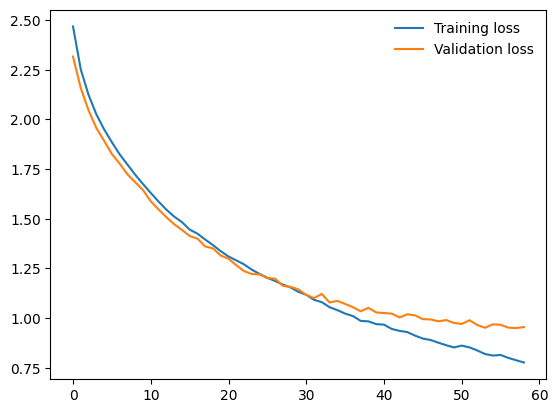

In [23]:
step = 0

#Training loop
train_losses = []
val_losses = []
patience = 5
best_loss = float('inf')
patience_counter = 0
best_val_loss = float('inf')
best_model_wts = None

for epoch in range(train_config['epochs']):
    try:
        if epoch == 26:
            save_weights_path = (
                "../../drive/MyDrive/MVA/".join(["finetune_intermediate_model", "epoch", str(epoch)]) + ".pth"
            )
            save_opt_path = (
                "../../drive/MyDrive/MVA/".join(["finetune_intermediate_optimizer", "epoch", str(epoch)]) + ".pth"
            )
            torch.save(model.state_dict(), save_weights_path)
            torch.save(optimizer.state_dict(), save_opt_path)
            print("Saved model and optimizer state at epoch 26.")
            train_losses_path = '../../drive/MyDrive/MVA/train_losses.csv'
            val_losses_path = '../../drive/MyDrive/MVA/val_losses.csv'
            with open(train_losses_path, 'w', newline='') as tr_csv_file:
                writer = csv.writer(tr_csv_file)
                writer.writerow(train_losses)
            with open(val_losses_path, 'w', newline='') as val_csv_file:
                writer = csv.writer(val_csv_file)
                writer.writerow(val_losses)

        # Model Training
        model.train()
        step += 1

        pbar = tqdm(train_loader)

        # track performance
        epoch_losses = torch.Tensor()
        metrics = PixelwiseMetrics(data_config['num_classes'])

        for idx, (img, y) in enumerate(pbar):
            # load target
            y = y.to(device)
            # model output
            y_hat = model(img)

            # loss computation
            loss = criterion(y_hat, y)

            # backward step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get prediction
            _, pred = torch.max(y_hat, dim=1)

            epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
            metrics.add_batch(y, pred)

            pbar.set_description(f"Epoch:{epoch}, Training Loss:{epoch_losses[-100:].mean():.4}")

        mean_loss = epoch_losses.mean()
        train_losses.append(mean_loss)
        train_stats = {
                "train_loss": mean_loss.item(),
                "train_average_accuracy": metrics.get_average_accuracy(),
                "train_mIoU": metrics.get_mIoU(),
                **{
                    "train_accuracy_" + k: v
                    for k, v in metrics.get_classwise_accuracy().items()
                },
                **{
                    "train_IoU_" + k: v
                    for k, v in metrics.get_IoU().items()
                },
            }
        print(train_stats)

        # Model Validation
        model.eval()
        pbar = tqdm(val_loader)

        # track performance
        epoch_losses = torch.Tensor()
        metrics = PixelwiseMetrics(data_config['num_classes'])

        with torch.no_grad():
            for idx, (img, y) in enumerate(pbar):
                y = y.to(device)
                # model output
                y_hat = model(img)

                # loss computation
                loss = criterion(y_hat, y)

                # get prediction
                _, pred = torch.max(y_hat, dim=1)

                epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
                metrics.add_batch(y, pred)


                pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

            mean_loss = epoch_losses.mean()
            val_losses.append(mean_loss)
            val_stats = {
                "validation_loss": mean_loss.item(),
                "validation_average_accuracy": metrics.get_average_accuracy(),
                "validation_mIoU": metrics.get_mIoU(),
                **{
                    "validation_accuracy_" + k: v
                    for k, v in metrics.get_classwise_accuracy().items()
                },
                **{
                "train_IoU_" + k: v
                for k, v in metrics.get_IoU().items()
            },
            }

            print(f"Epoch:{epoch}", val_stats)

            # Save model checkpoint every 2 epochs
            if epoch % 2 == 0:
                if epoch == 0:
                    continue

                save_weights_path = (
                    "checkpoints/" + "-".join(["segmentation", "epoch", str(epoch)]) + ".pth"
                )
                save_opt_path = (
                    "checkpoints/" + "-".join(["optimizer", "epoch", str(epoch)]) + ".pth"
                )
                torch.save(model.state_dict(), save_weights_path)
                torch.save(optimizer.state_dict(), save_opt_path)
            val_loss = val_stats["validation_loss"]
            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
                best_model = model.state_dict()
                best_epoch = epoch
                print("For now best val loss at epoch: ", epoch)
                # Enregistrez les meilleurs poids ici si désiré
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    torch.save(model.state_dict(), '../../drive/MyDrive/MVA/swin-t_SSL_finetune_3_earlyStopped_'+str(epoch)+'.pth')
                    break
    except Exception as e:
        print(f"An error occurred: {e}")
        print(f"Memory usage: {psutil.virtual_memory()}")
        print(f"GPU usage: {GPUtil.getGPUs()}")

torch.save(best_model, "../../drive/MyDrive/MVA/swin-t_SSL_finetune_3_"+str(best_epoch))
print(f"Best model from validation saved to ../../drive/MyDrive/MVA/swin-t_SSL_finetune_3")
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

You can evaluate the model on one example by creating a model's instance, loading checkpoint's weights of the classifier saved during training, running it, and displaying the results:

In [23]:
def test(model, test_ld):
    model.eval()
    pbar = tqdm(test_ld)

    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['num_classes'])
    all_preds = []
    all_gts = []
    with torch.no_grad():
        for idx, (img, y) in enumerate(pbar):
            y = y.to(device)
            # model output
            y_hat = model(img)

            # loss computation
            loss = criterion(y_hat, y)

            # get prediction
            _, pred = torch.max(y_hat, dim=1)
            all_gts.append(y.cpu().numpy())
            all_preds.append(pred.cpu().numpy())
            epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
            metrics.add_batch(y, pred)


            pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

        mean_loss = epoch_losses.mean()
        test_stats = {
            "test_loss": mean_loss.item(),
            "test_average_accuracy": metrics.get_average_accuracy(),
            "test_mIoU": metrics.get_mIoU(),
            **{
                "test_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
                "train_IoU_" + k: v
                for k, v in metrics.get_IoU().items()
            },
        }
        print("Test stats:")

        # Loss
        print(f"  Loss: {test_stats['test_loss']:.4f}")

        # Average accuracy and mIoU
        print(f"  Average Accuracy: {test_stats['test_average_accuracy']:.4f}")
        print(f"  Mean IoU: {test_stats['test_mIoU']:.4f}")

        # Accuracy per class
        print("  Accuracy by Class:")
        for i in range(data_config['num_classes']):
            print(f"    Class {i}: {test_stats[f'test_accuracy_pixelclass_{i}']:.4f}")

        # IoU per class
        print("  IoU by Class:")
        for i in range(data_config['num_classes']):
            print(f"    Class {i}: {test_stats[f'train_IoU_class_{i}']:.4f}")
        all_preds = np.concatenate(all_preds)
        all_gts = np.concatenate(all_gts)

        # Calculer la matrice de confusion
        conf_matrix = confusion_matrix(all_gts.flatten(), all_preds.flatten(), labels=np.arange(data_config['num_classes']))
        # Normalisation par lignes
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        sns.set(font_scale=0.8)

        # Tracer la matrice de confusion
        plt.figure(figsize=(10, 10))
        ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=list(dict_classes_13.values()), yticklabels=list(dict_classes_13.values()))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        #sns.set(font_scale=1.2)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
    return

In [ ]:
torch.save(model.state_dict(), '../../drive/MyDrive/MVA/swin-t_SSL_freeze_60epochs.pth')
# torch.save(model.state_dict(), 'checkpoints/segmentation-epoch-28.pth')

Validation Loss:0.9585: 100%|██████████| 33/33 [01:07<00:00,  2.05s/it]


Test stats:
  Loss: 0.9585
  Average Accuracy: 0.5272
  Mean IoU: 0.4161
  Accuracy by Class:
    Class 0: 0.7844
    Class 1: 0.2523
    Class 2: 0.7788
    Class 3: 0.0651
    Class 4: 0.7780
    Class 5: 0.4831
    Class 6: 0.8311
    Class 7: 0.3565
    Class 8: 0.7730
    Class 9: 0.7764
    Class 10: 0.3550
    Class 11: 0.6200
    Class 12: 0.0000
  IoU by Class:
    Class 0: 0.6151
    Class 1: 0.1850
    Class 2: 0.5892
    Class 3: 0.0646
    Class 4: 0.6521
    Class 5: 0.4165
    Class 6: 0.6783
    Class 7: 0.2614
    Class 8: 0.7142
    Class 9: 0.5128
    Class 10: 0.2795
    Class 11: 0.4403
    Class 12: 0.0000


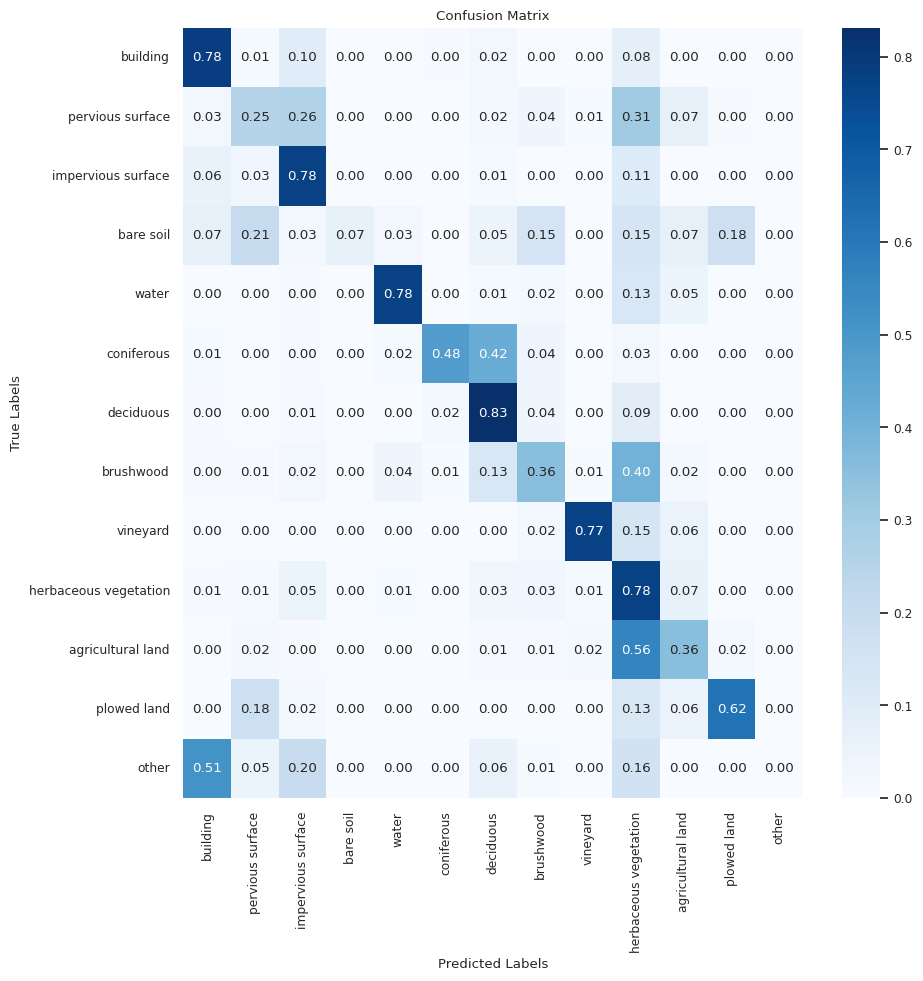

In [24]:
# create a new model's instance
model = DoubleSwinTransformerSegmentation(
        s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device)

model = model.to(device)

# load checkpoints weights
model.load_state_dict(torch.load('../../drive/MyDrive/MVA/swin-t_SSL_finetune_3_58'))#../../drive/MyDrive/MVA/swin-t_SSL_freeze_3_40'))#

test(model, test_loader)